In [1]:
import numpy as np
import pandas as pd
import healpy as hp
%config InlineBackend.figure_format = 'retina'
from DS_Planck_Unet import west_val, east_val
from matplotlib import pyplot as plt
from DS_Planck_Unet import load_planck_model, draw_pic_with_mask, draw_pic, val_pix
from DS_healpix_fragmentation import *
from DS_data_transformation import pic2fits
from DS_detector import *
import os
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
from DS_data_transformation import normalize
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from scipy.special import logit

In [ ]:
a = np.zeros(hp.nside2npix(2))
a[west_val] = 1
a[east_val] = 2

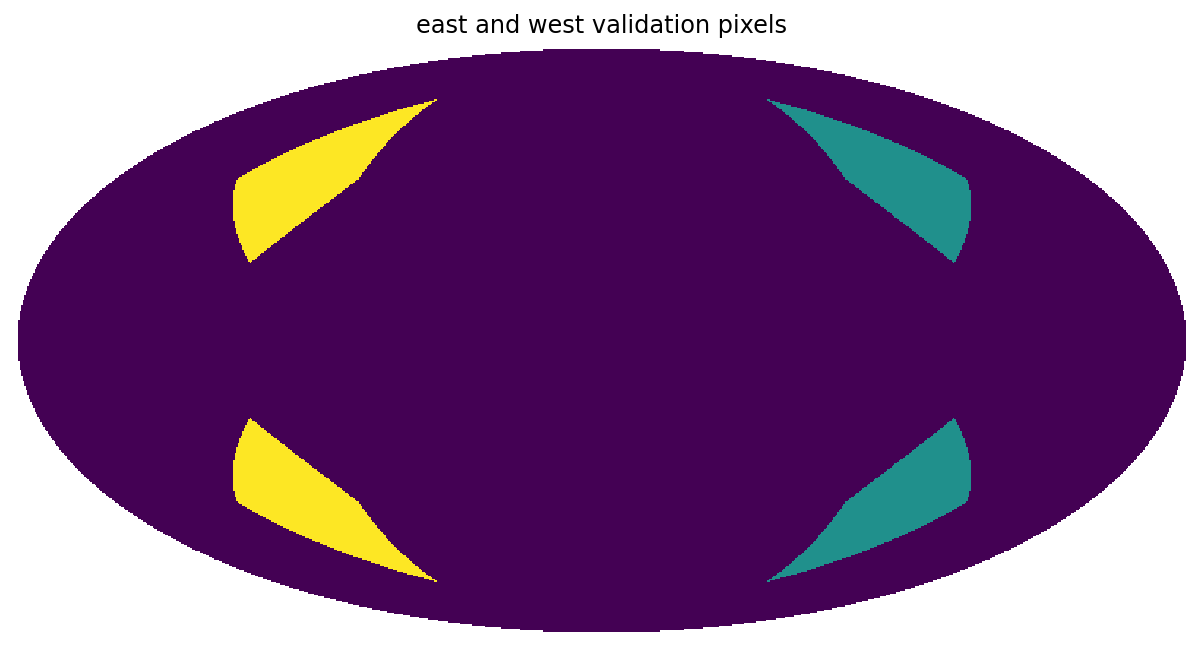

In [7]:
hp.mollview(a, nest=True, title='east and west validation pixels', cbar=False)

In [2]:
pix2 = east_val[0]
print(pix2, 'pix2')
cat = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_rot28_thr0.1_step8_no_fn.csv')
cat = cat[cat['status'] == 'tp']
cat = cat[cat['catalog'] == 'planck_z']
cat = cat[radec2pix(cat['tRA'], cat['tDEC'], 2) == pix2]
cat.index = np.arange(len(cat))
cat['pix'] = radec2pix(cat['tRA'], cat['tDEC'], 2**11)
print(cat.shape, 'cluster')
size = 16
coords = np.stack([cat['tRA'], cat['tDEC']]).T
print(coords.shape, 'coords')
matr = one_pixel_fragmentation(2, pix2, 10)
mdict = matr2dict(matr)
cat['x'] = 0
cat['y'] = 0

38 pix2
(48, 16) cluster
(48, 2) coords


In [3]:
all_model = load_planck_model('/home/rt2122/Models/all_found/all_found.ep0034-vl0.009741-l0.008339.hdf5')

In [4]:
all_data_dict = gen_pics_for_detection(pix2, all_model, step=4, only=True, data_type=np.float)
all_connected = connect_masks(all_data_dict['ans'], all_data_dict['pic_idx'], data_type=np.float16)
del all_data_dict

In [11]:
pic, mask = draw_pic_with_mask(None, coords, matr=matr)
ypic = draw_pic(matr, y=True)
cm1 = sns.light_palette("red", as_cmap=True)
cm2 = sns.light_palette("gray", as_cmap=True)
def pic9(idx): 
    print(cat.iloc[idx])
    x_cl, y_cl = mdict[radec2pix(*coords[idx], 2**11)]
    sm_pic = pic[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_ypic = ypic[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_mask = mask[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_matr = matr[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    sm_mdict = matr2dict(sm_matr)
    sm_all = all_connected[x_cl-size:x_cl+size, y_cl-size:y_cl+size]
    s = 100
    
    x_dr = []
    y_dr = []
    for p in radec2pix(coords[:, 0], coords[:, 1], 2**11):
        if p in sm_mdict:
            x, y = sm_mdict[p]
            x_dr.append(x)
            y_dr.append(y)
    _, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.001)
    
    pic_dict = {6 : logit(sm_all), 7 : sm_ypic, 8:sm_mask}
    
    for i in range(3):
        for j in range(3):
            if 3*i+j < 6:
                ax[i][j].imshow(sm_pic[:,:,3*i+j])#, vmin=val_min[4*i+j], vmax=val_max[4*i+j])#, cmap=cmg)
                #ax[i][j].imshow(sm_mask[:,:,0], alpha=0.5*sm_mask[:,:,0].astype(float), cmap=cm2)
            else:
                ax[i][j].imshow(pic_dict[3*i+j][:,:,0])#, cmap=cmg)
                #ax[i][j].imshow(sm_mask[:,:,0], alpha=0.5*sm_mask[:,:,0].astype(float), cmap=cm2)
    for i in range(3):
        for j in range(3):
            #for k in range(len(cat)):
            #    x = cat['x'][i]
            #    y = cat['y'][i]
            #    if x in range(2 * size) and y in range(2 * size):
                ax[i][j].scatter(y_dr, x_dr, marker='x', c='r', s=s)
            
    ax[2][1].set_xlabel('y map')
    ax[2][0].set_xlabel('Best model prediction')
    ax[2][2].set_xlabel('Ground truth mask')


RA           20.4132
DEC          20.1231
area              24
min_rad      1.61885
max_rad      3.84243
mean_rad     2.85872
min_pred    0.135892
max_pred    0.899619
tRA          20.4346
tDEC         20.1398
status            tp
catalog     planck_z
M500         3.98676
z           0.193982
pix2         val_pix
pix         40196609
x                  0
y                  0
Name: 1, dtype: object


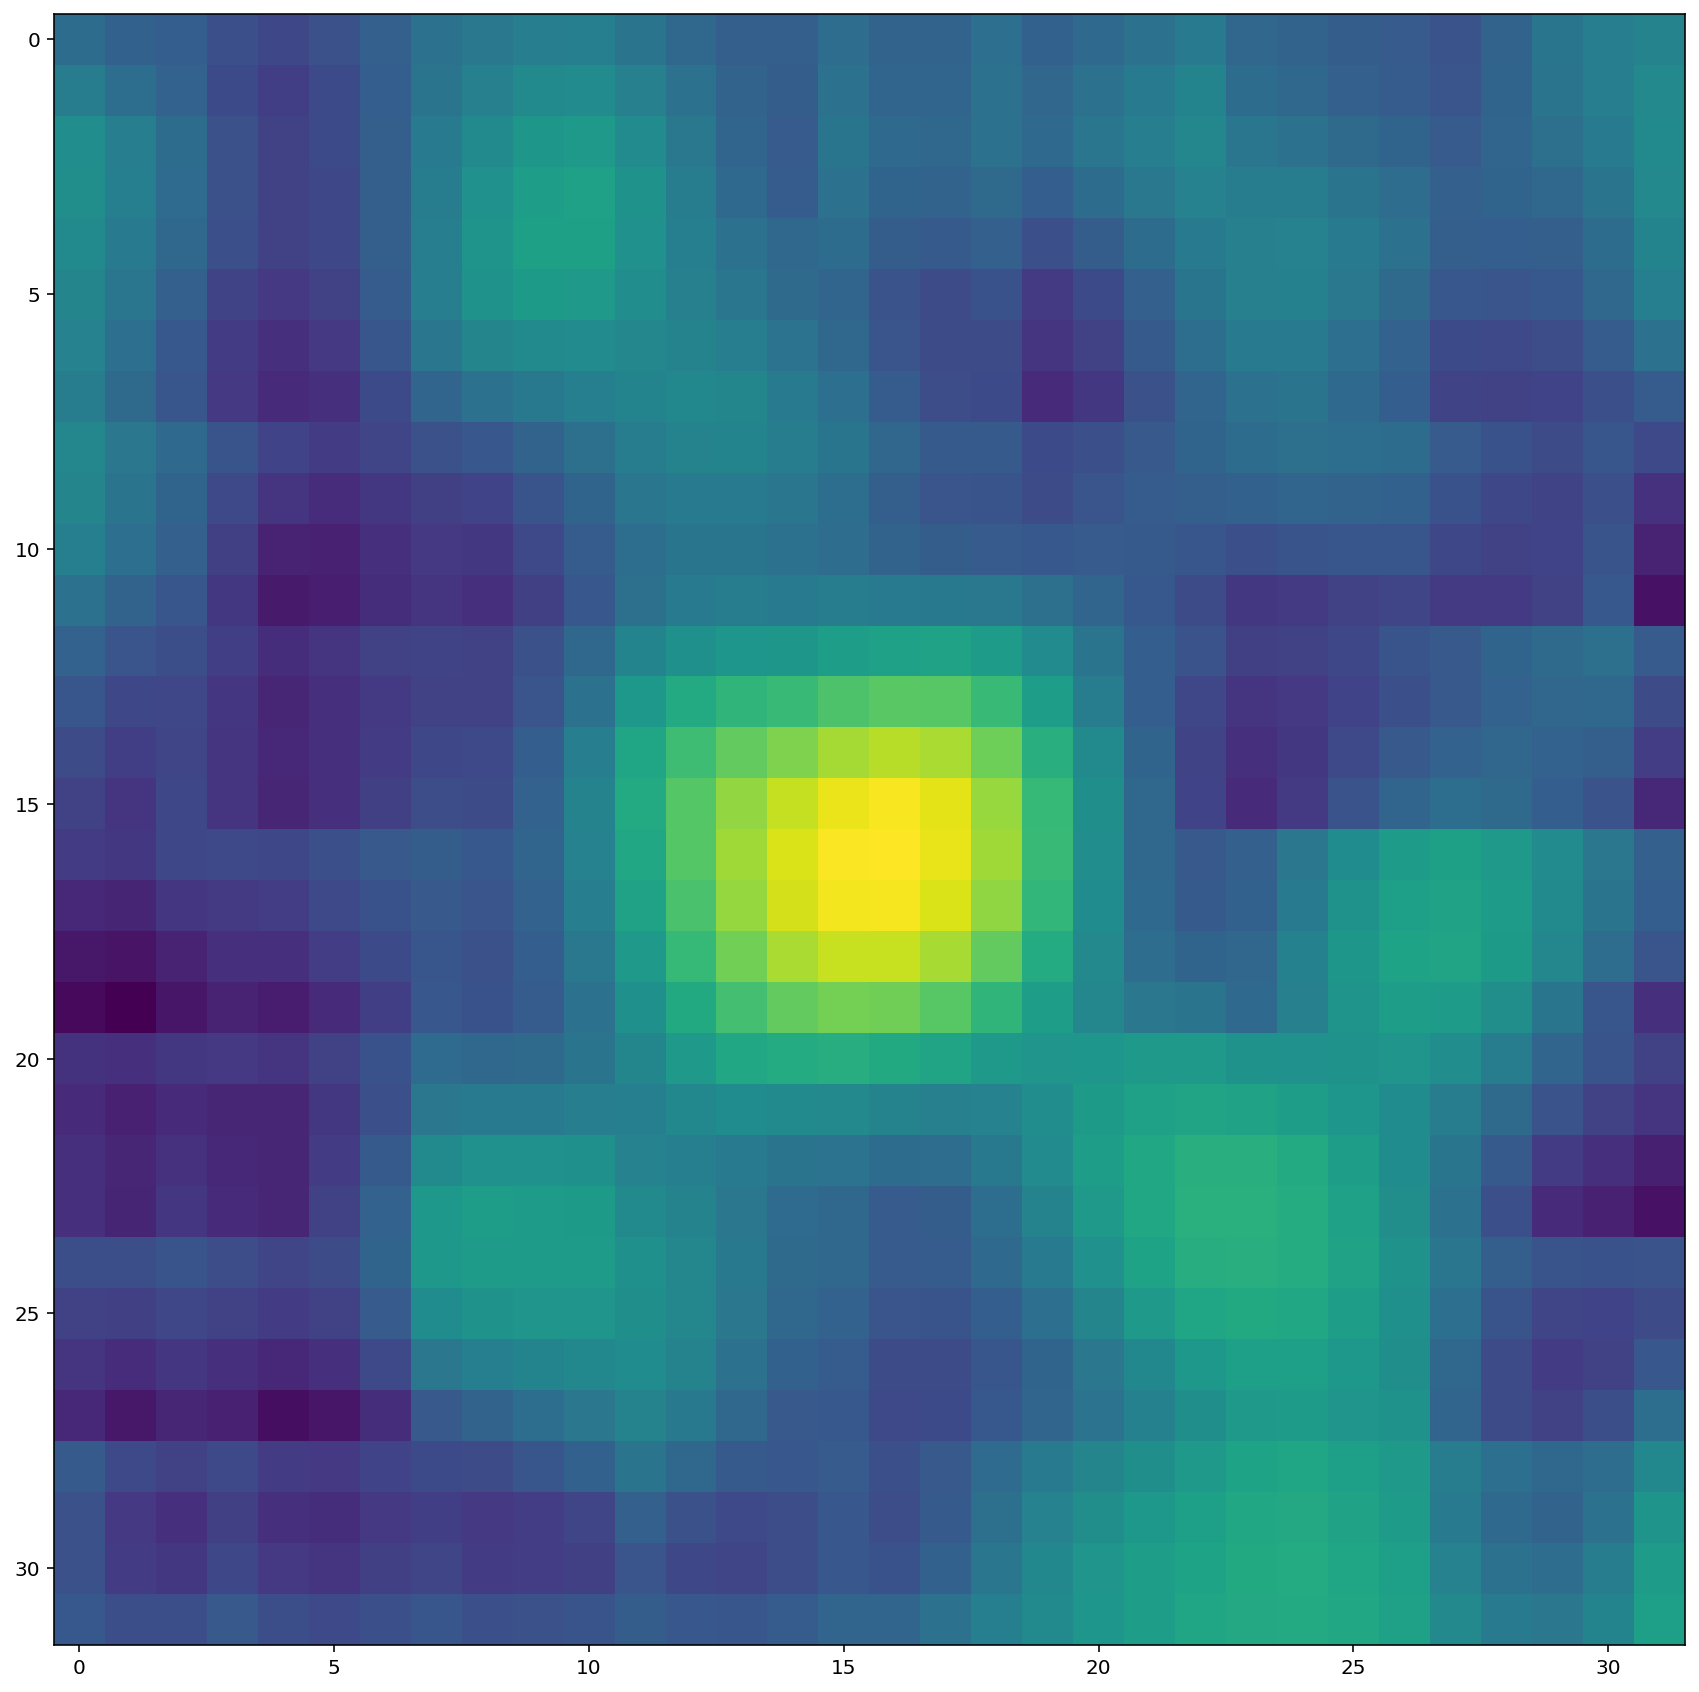

In [12]:
pic9(1)

RA           2.55509
DEC           6.6322
area              12
min_rad     0.998688
max_rad      3.16757
mean_rad      2.0952
min_pred    0.101113
max_pred    0.278512
tRA           2.5584
tDEC         6.63386
status            tp
catalog     planck_z
M500         4.79848
z           0.291234
pix2         val_pix
pix         39911248
x                  0
y                  0
Name: 6, dtype: object


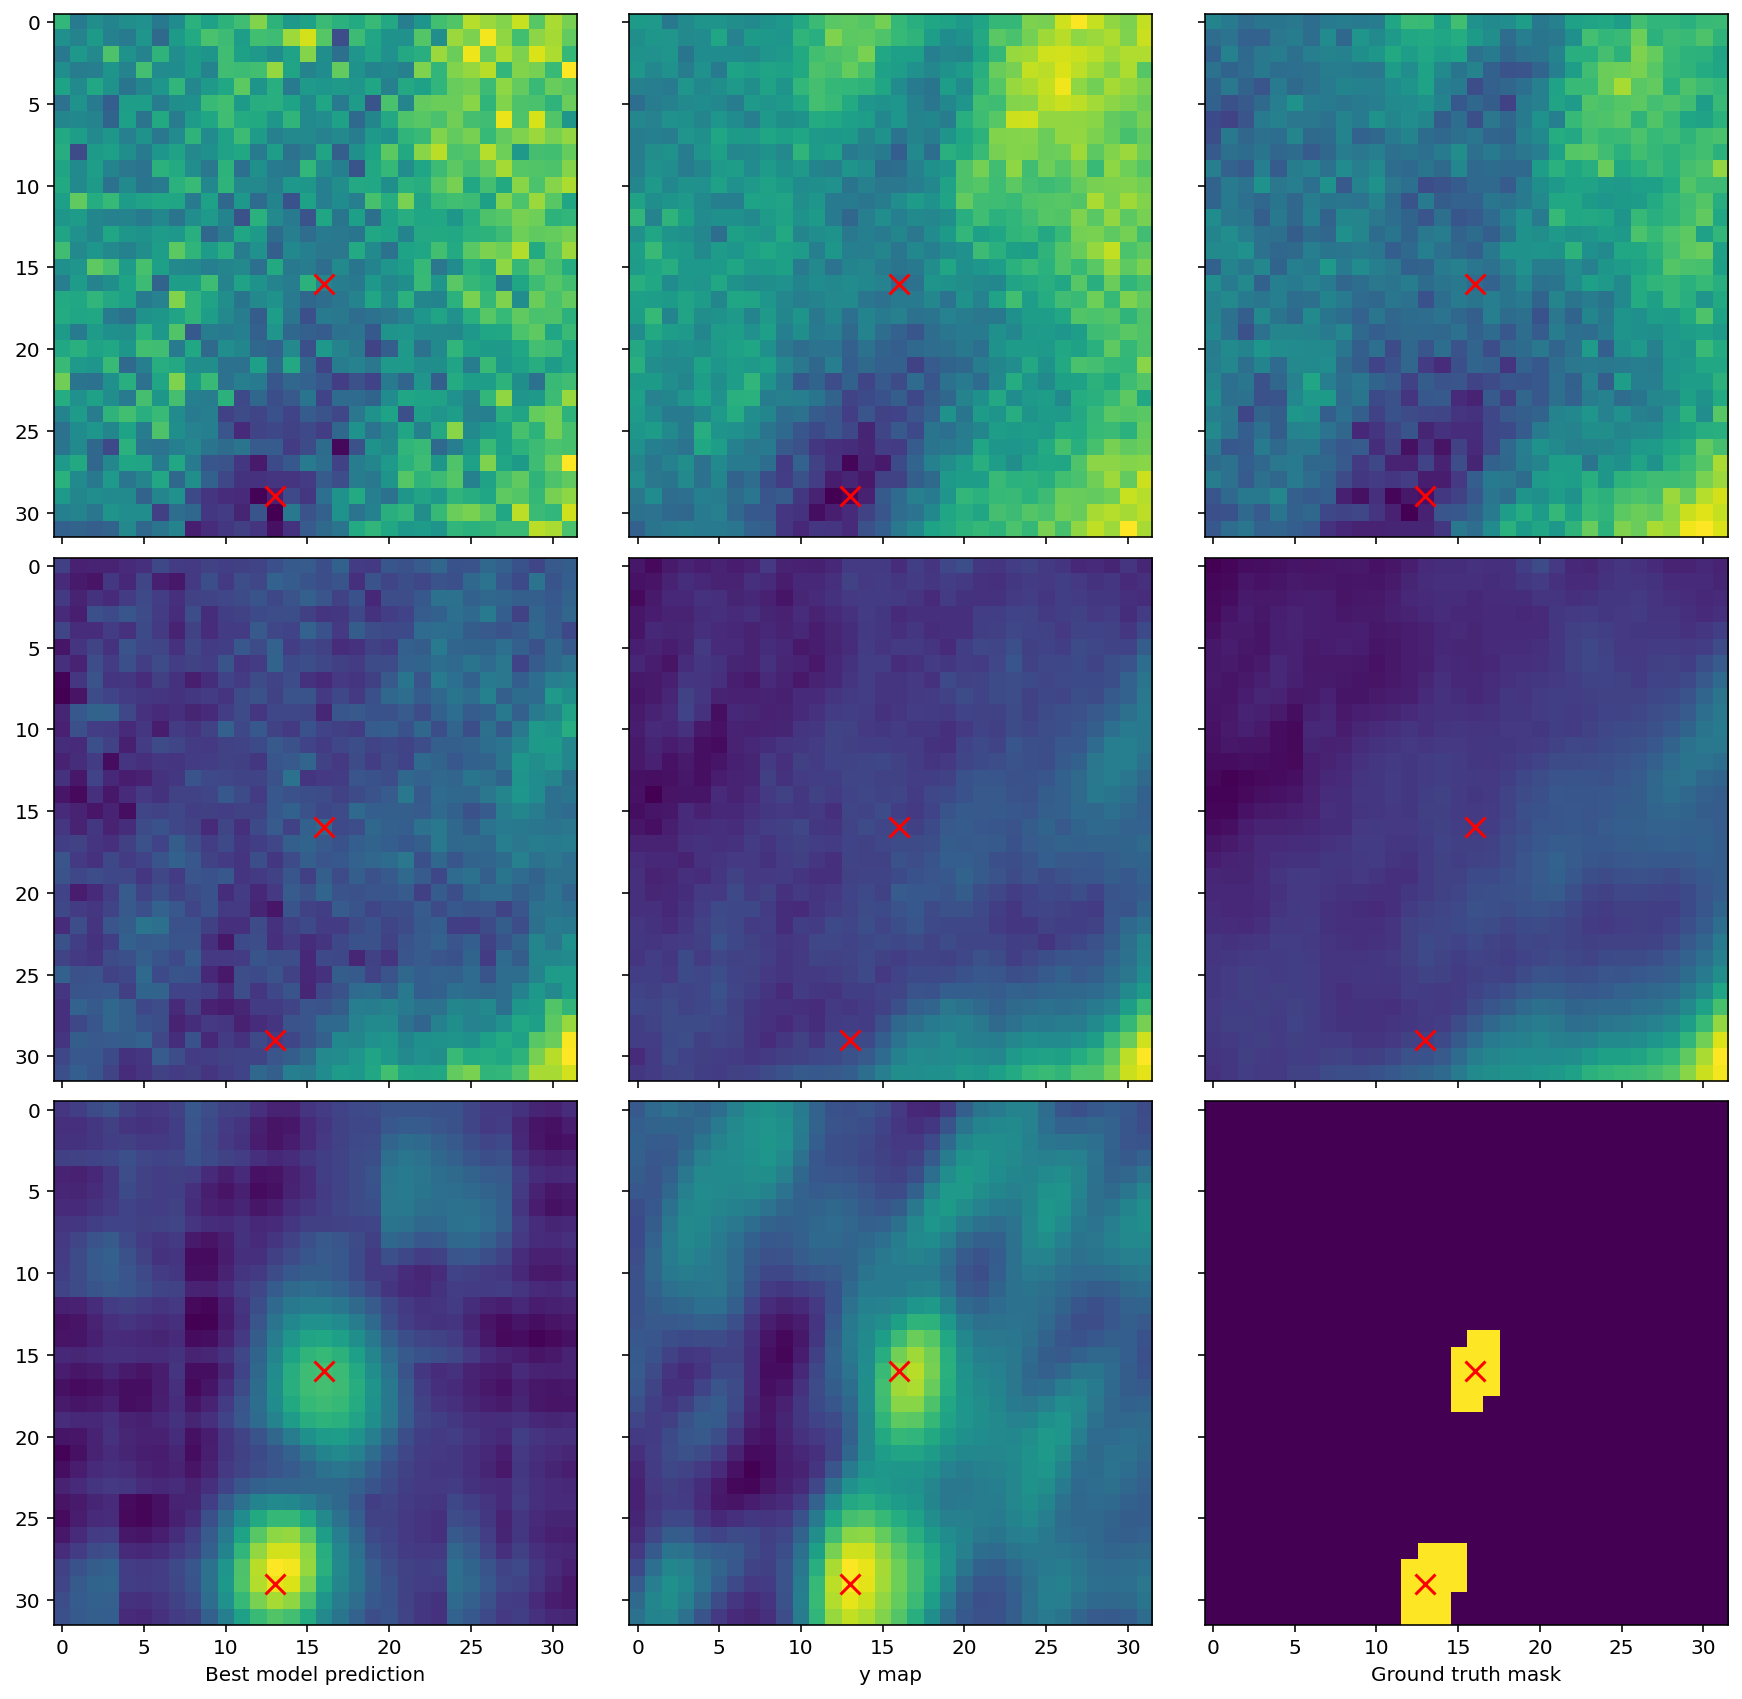

In [7]:
pic9(6)

In [31]:
def plot_history(hist_file, loss_tick=None, cut_eps=[0, -1], major_xticks=None):
    import pickle
    import pandas as pd
    import numpy as np
    from matplotlib import pyplot as plt
    
    hist = None
    with open(hist_file, 'rb') as f:
        hist = pickle.load(f)
        hist = pd.DataFrame(hist, index=np.arange(1, len(hist['loss']) + 1))
    _, ax = plt.subplots(1, 2, figsize=(18,5))
    
    hist = hist.iloc[cut_eps[0]:cut_eps[1]]
    
    line, = ax[0].plot(hist.index, hist['loss'], 'co-')
    line.set_label('Loss')
    line, = ax[0].plot(hist.index, hist['val_loss'], 'co-', alpha=0.5)
    line.set_label('Validation loss')
    
    names = {'iou' : 'IoU', 'dice' : 'Dice'}
    for c, metr in zip('rb', ['iou', 'dice']):
        line, = ax[1].plot(hist.index, hist[metr], c+'o-')
        line.set_label(names[metr])
        line, = ax[1].plot(hist.index, hist['val_'+metr], c+'o-', alpha=0.5)
        line.set_label('Validation ' + names[metr])
    
    if major_xticks is None:
        major_xticks = hist.index[4::5]
    
    for i in range(2):
        ax[i].legend()
        ax[i].set_xticks(hist.index, minor=True)
        ax[i].set_xticks(major_xticks)
        ax[i].grid(True, axis='both', which='major')
        ax[i].grid(True, axis='both', which='minor', alpha=0.2)
        ax[i].set_xlabel('Epochs')
    if not (loss_tick is None):
        ax[0].set_yticks(loss_tick[::5])
        ax[0].set_yticks(loss_tick, minor=True)
    ax[0].set_ylabel('Binary crossentropy')
    ax[1].set_ylabel('IoU / Dice')

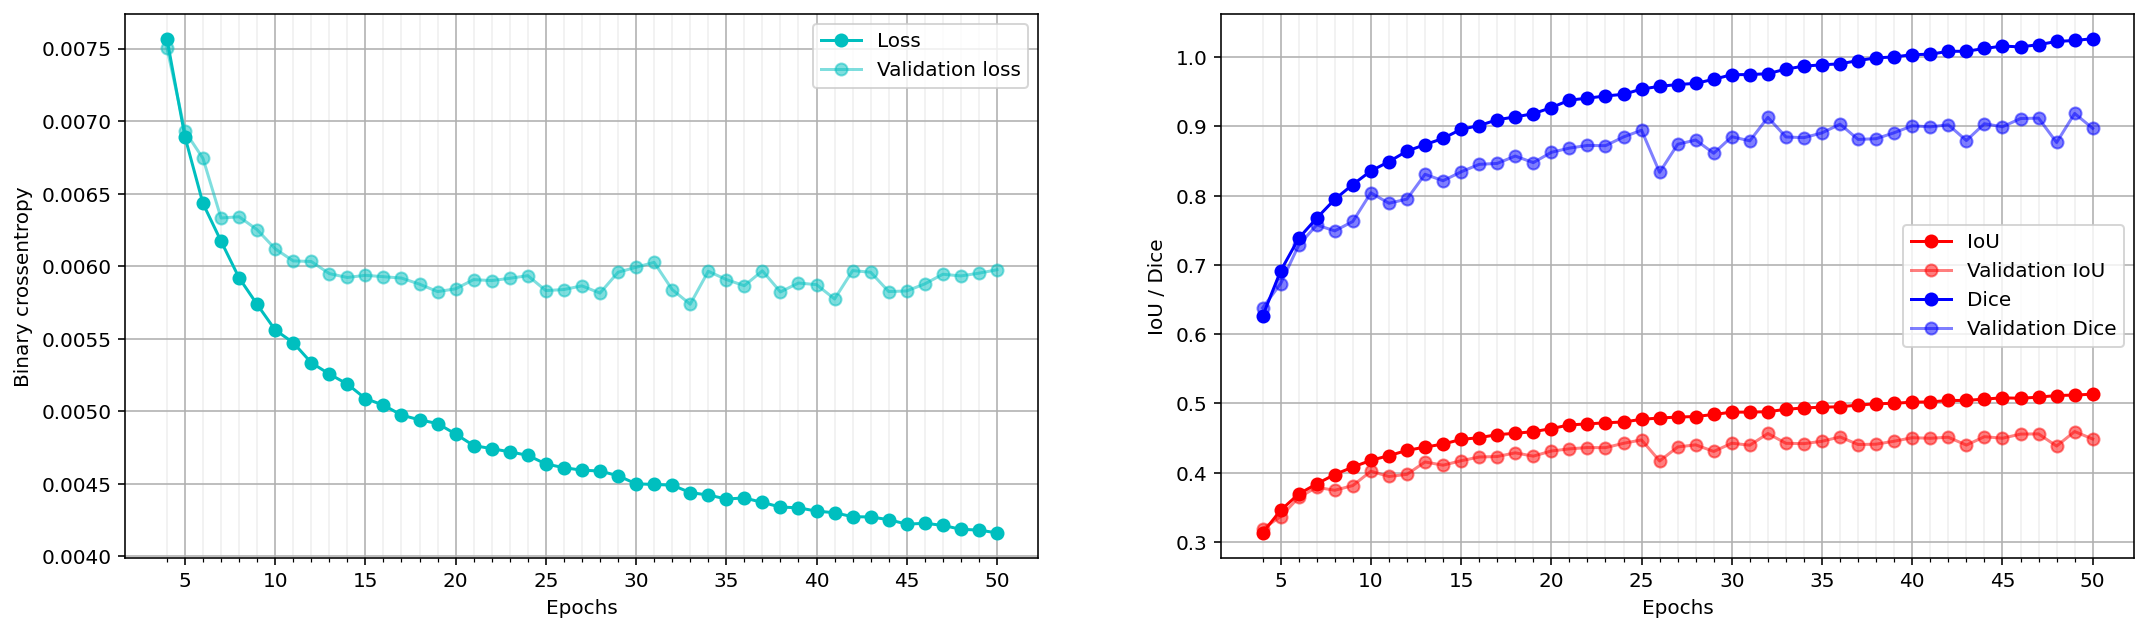

In [35]:
plot_history('/home/rt2122/Models/pz_only_rot/pz_only_rot.ep1-50.history', cut_eps=[3, 50], major_xticks=np.arange(5, 51, 5))

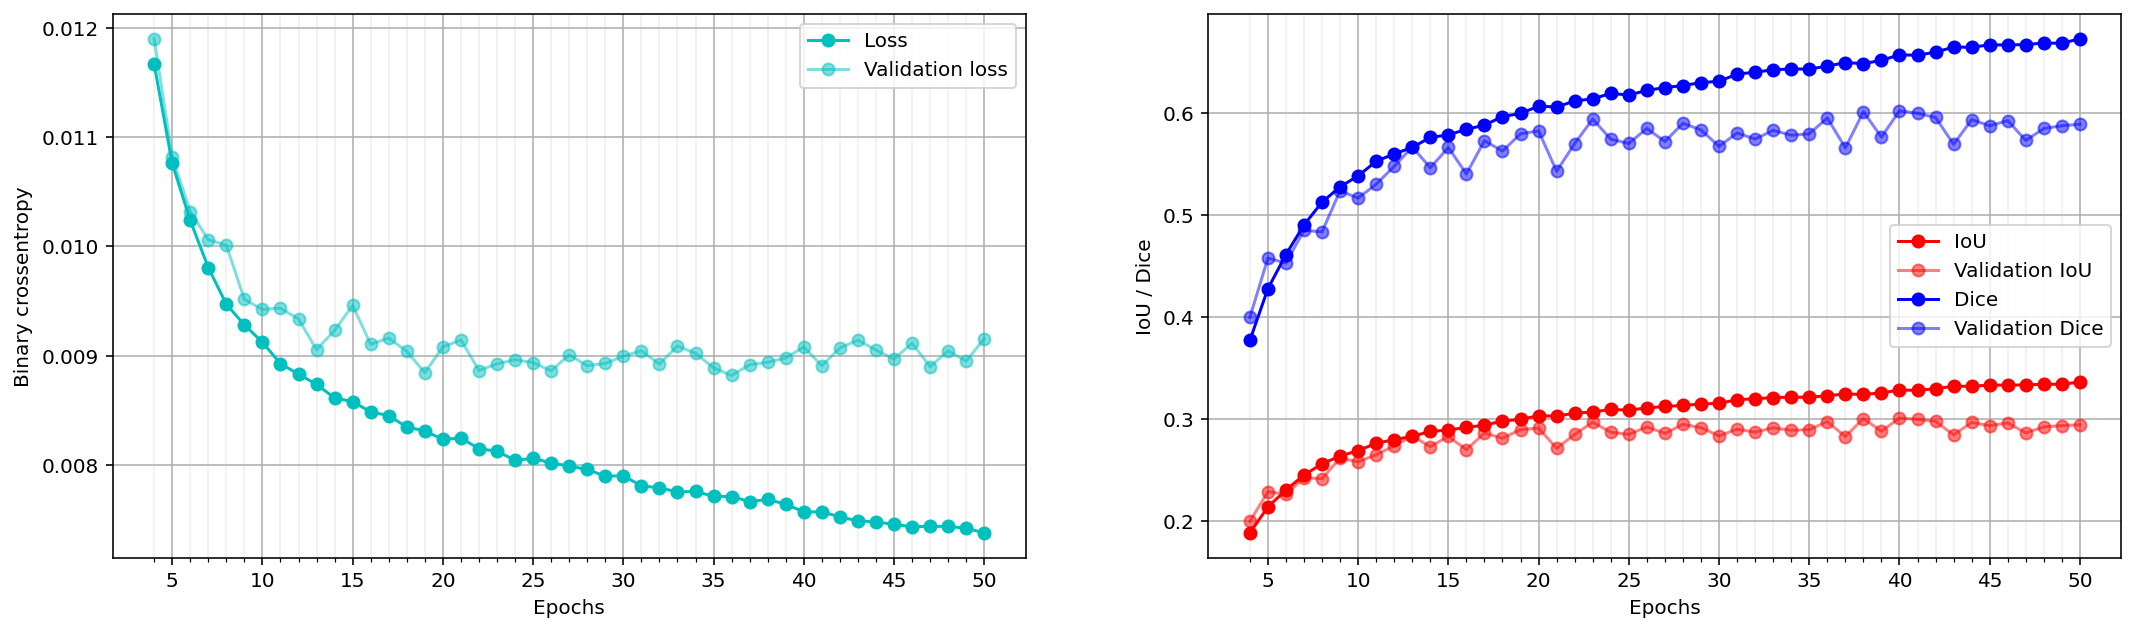

In [36]:
plot_history('/home/rt2122/Models/act_found2/act_found2.ep1-50.history', cut_eps=[3, 50], major_xticks=np.arange(5, 51, 5))

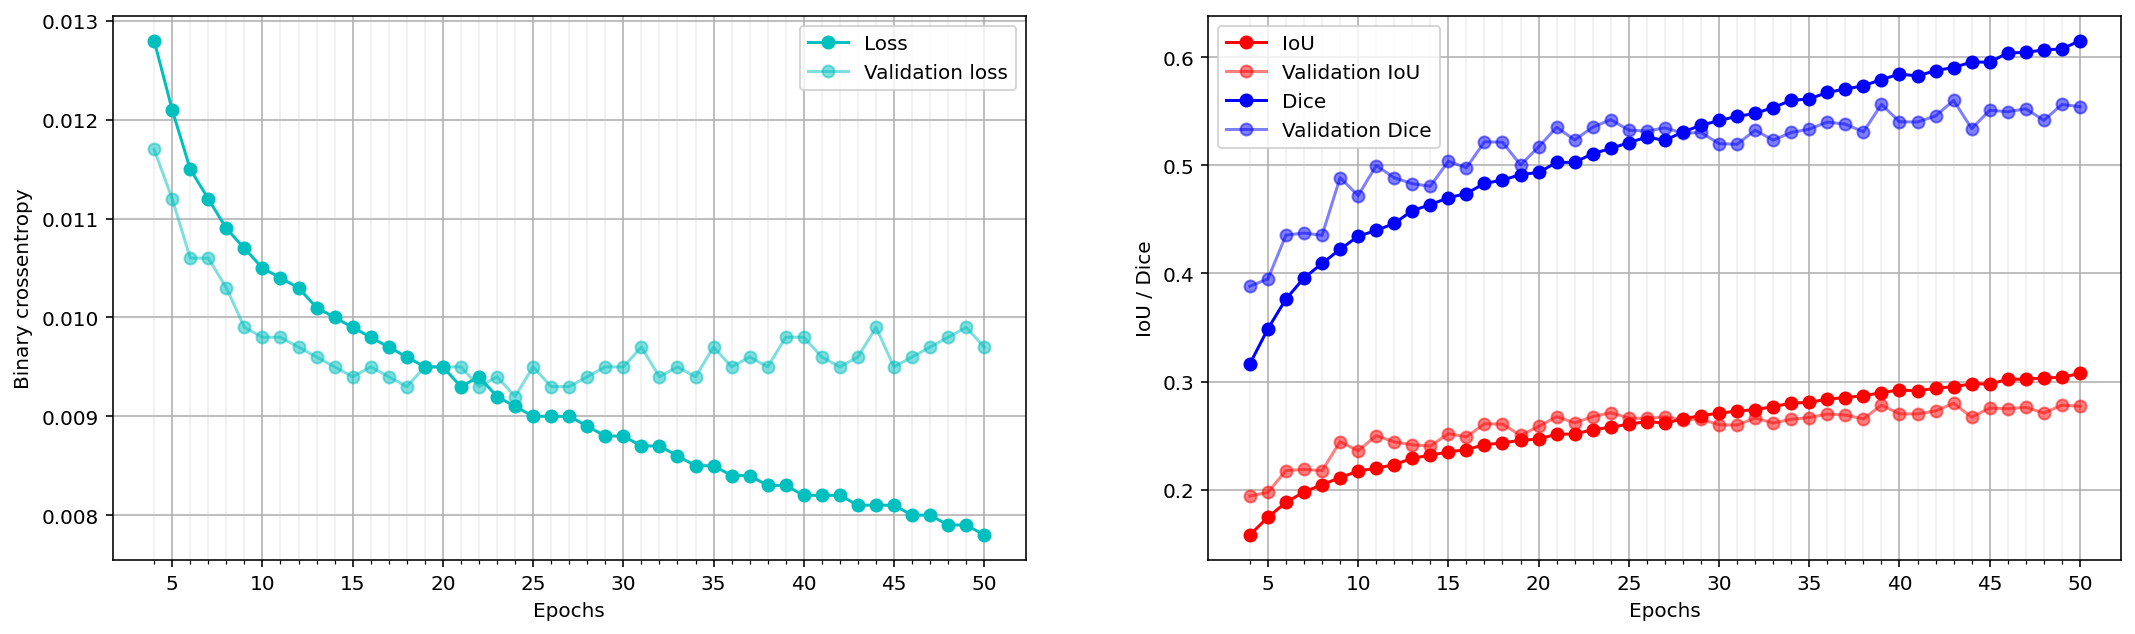

In [37]:
plot_history('/home/rt2122/Models/all_found4/all_found4.ep1-50.history', cut_eps=[3, 50], major_xticks=np.arange(5, 51, 5)) #здесь валидация - западная часть

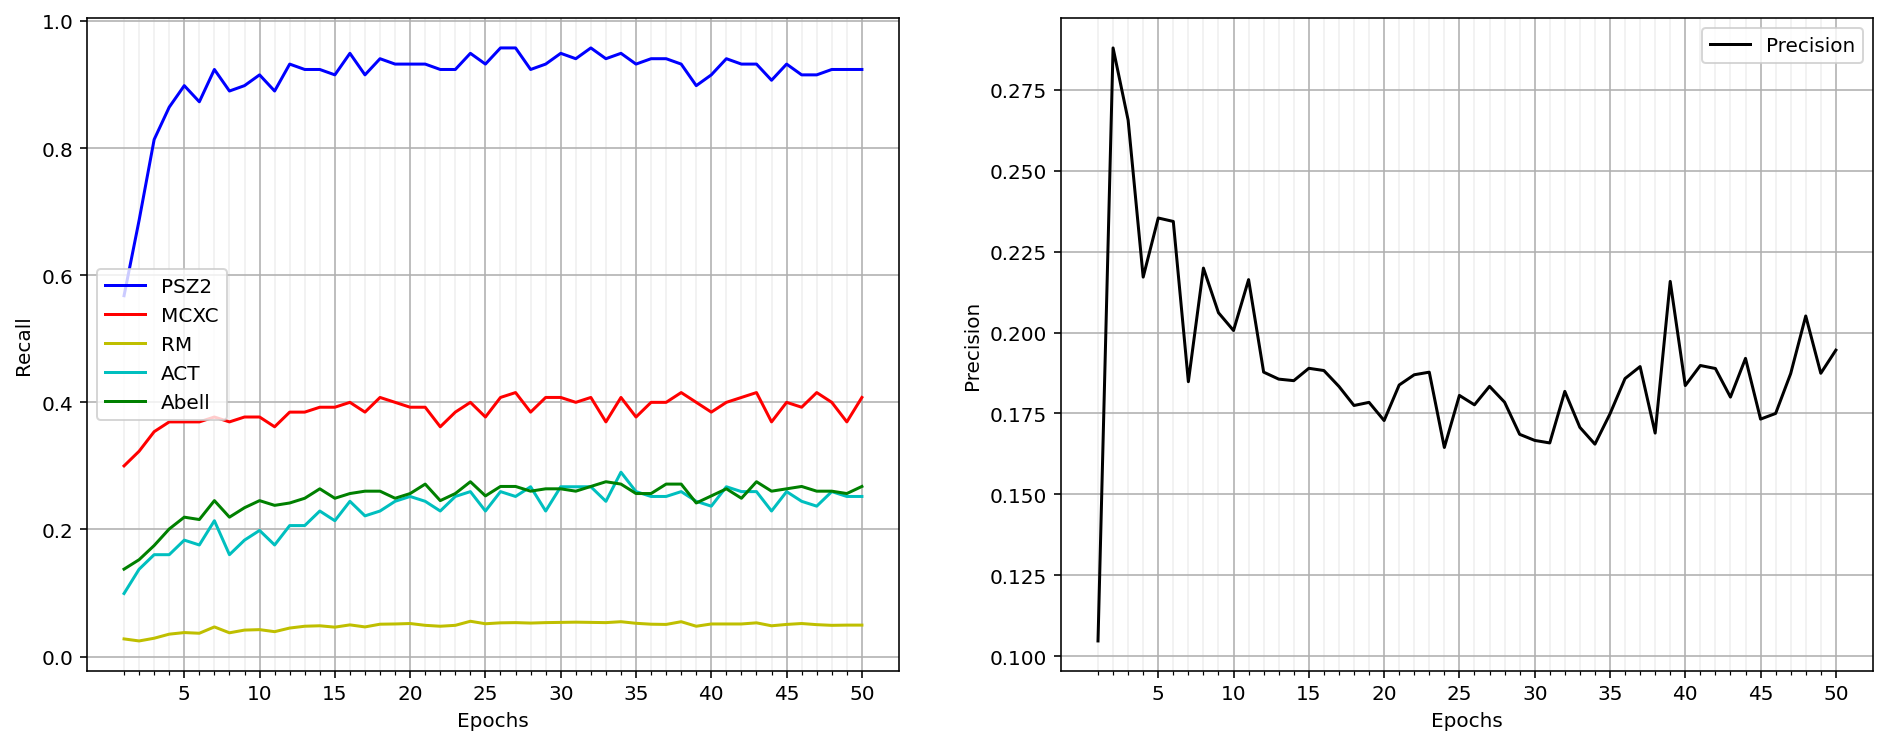

In [14]:
recall_df = pd.read_csv('/home/rt2122/Data/models_stat/all_found4_recall.csv', index_col='epoch')
_, ax = plt.subplots(1, 2, figsize=(16, 6))
for c, name in zip('brycg', ['PSZ2', 'MCXC', 'RM', 'ACT', 'Abell']):
    s, = ax[0].plot(recall_df.index, recall_df[name], c=c)
    s.set_label(name)
ax[0].set_ylabel('Recall')
s, = ax[1].plot(recall_df.index, recall_df['precision'], c='k')
s.set_label('Precision')
ax[1].set_ylabel('Precision')

for i in range(2):
    ax[i].set_xlabel('Epochs')
    ax[i].set_xticks(recall_df.index, minor=True)
    ax[i].set_xticks(recall_df.index[4::5])
    ax[i].grid(True, axis='both', which='major')
    ax[i].grid(True, axis='both', which='minor', alpha=0.2)
    ax[i].legend()

In [2]:
def make_histogram(ax, tp, fp, n_bins, label1='Yes matches', label2='No matches'):
    ax.hist(tp, n_bins, color='r', log=True, histtype='step', label=label1)
    ax.hist(fp, n_bins, color='b', log=True, histtype='step', label=label2)
    ax.legend()

In [25]:
def match_2circles(ax, det_cat, true_cat, n_bins=20, small_circle=400/3600, big_circle=1500/3600, max_pred_lim=None):
    if not (max_pred_lim is None):
        det_cat = det_cat[det_cat['max_pred'] >= max_pred_lim]
        det_cat.index = np.arange(len(det_cat))
    det_sc = SkyCoord(ra=np.array(det_cat['RA'])*u.degree, dec=np.array(det_cat['DEC'])*u.degree, frame='icrs')
    tr_sc = SkyCoord(ra=np.array(true_cat['RA'])*u.degree, dec=np.array(true_cat['DEC'])*u.degree, frame='icrs')
   
    idx, d2d, _ = det_sc.match_to_catalog_sky(tr_sc)
    matched_small = d2d.degree <= small_circle
    not_matched_small = np.logical_not(matched_small) 
    
    tr_sc = SkyCoord(ra=np.array(true_cat['RA'][list(set(idx[not_matched_small]))])*u.degree, 
                     dec=np.array(true_cat['DEC'][list(set(idx[not_matched_small]))])*u.degree, frame='icrs')
    idx, d2d, _ = det_sc.match_to_catalog_sky(tr_sc)
    matched_big = np.logical_and(d2d.degree > small_circle, d2d.degree <= big_circle)
    
    
    make_histogram(ax, det_cat['max_pred'][matched_small], det_cat['max_pred'][matched_big], n_bins)

(1653,)
1543
1572
(1572,)


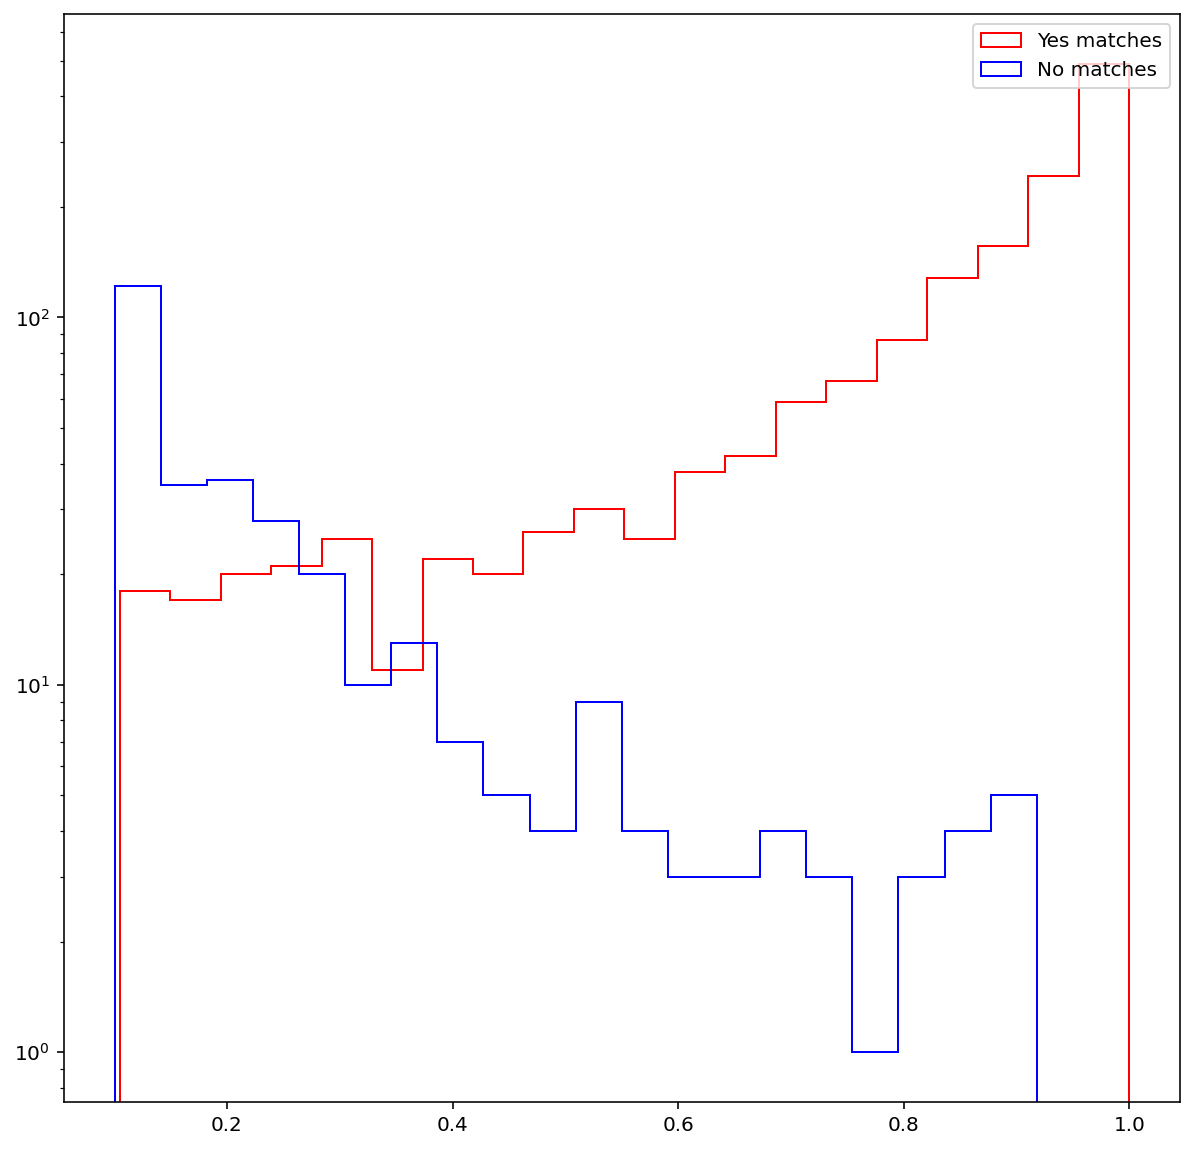

In [18]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))
match_2circles(ax, pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv'), 
              pd.read_csv('/home/rt2122/Data/original_catalogs/csv/PSZ2.csv'))

In [20]:
dirname = '/home/rt2122/Data/original_catalogs/csv/'
true_cats = next(os.walk(dirname))[-1]
true_cats = [os.path.join(dirname, s) for s in true_cats]
det_cat = '/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv'

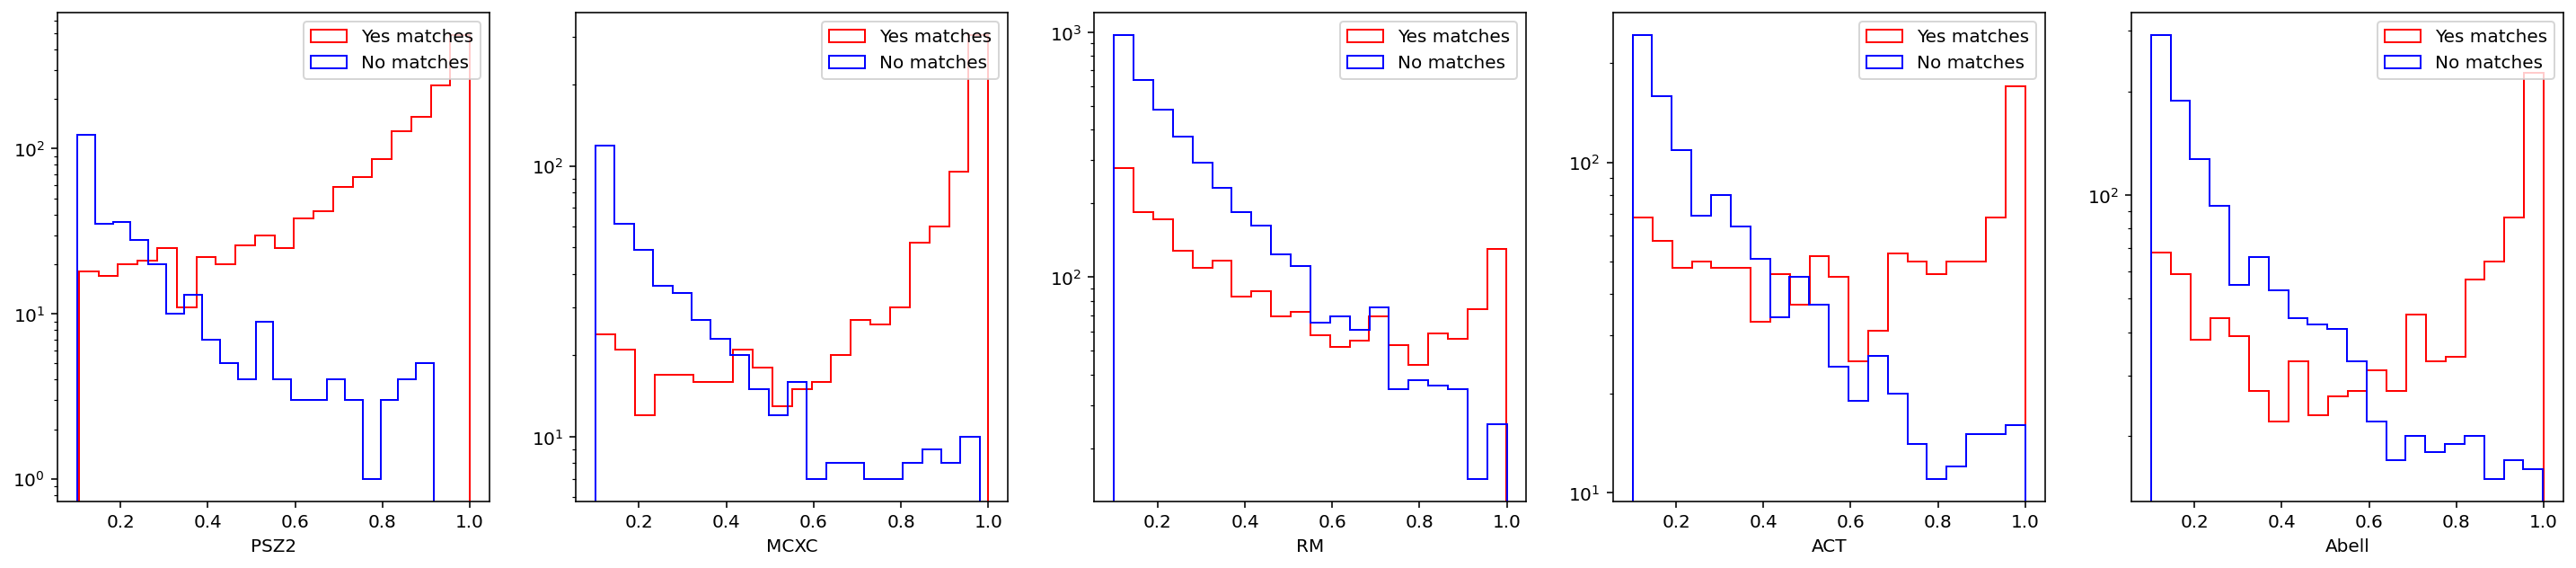

In [24]:
_, ax = plt.subplots(1, len(true_cats), figsize=(len(true_cats) * 5, 5))
for i, tr_cat in enumerate(true_cats):
    match_2circles(ax[i], pd.read_csv(det_cat), pd.read_csv(tr_cat))
    ax[i].set_xlabel(os.path.splitext(os.path.basename(tr_cat))[0])

1) Создаем координаты для детектированного каталога и для ground truth каталога <br>
2) Сопоставляем координаты: для каждого объекта из дет. каталога находим ближайшее скопление из gt-каталога <br>
3) В детектированном каталоге есть объекты, для которых в радиусе small_rad (400'') найдено скопление в gt-каталоге - это красная выборка<br>
4) Из gt-каталога исключаем те объекты, которые были сопоставлены с объектами из детектированного каталога в п.3<br>
5) Снова сопоставляем координаты детектированного каталога с новой версией gt-каталога: теперь мы выбираем те объекты, для которых ближйшее скопление находится в промежутке (small_rad, big_rad] ((400'', 1500'']) - это синяя выборка<br>

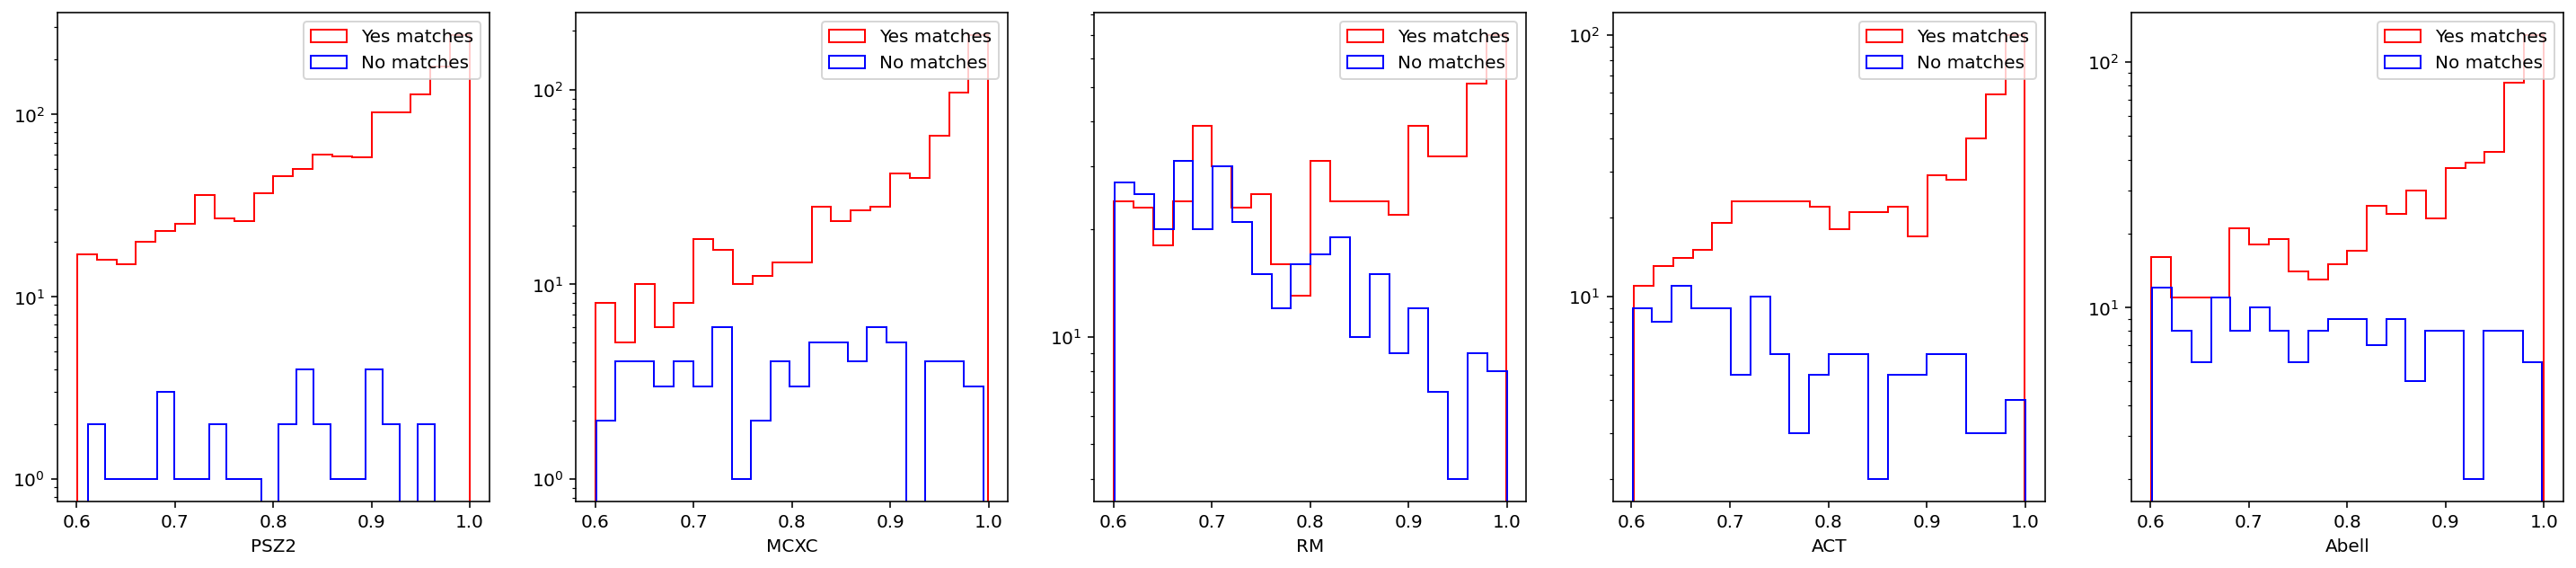

In [26]:
_, ax = plt.subplots(1, len(true_cats), figsize=(len(true_cats) * 5, 5))
for i, tr_cat in enumerate(true_cats):
    match_2circles(ax[i], pd.read_csv(det_cat), pd.read_csv(tr_cat), max_pred_lim=0.6)
    ax[i].set_xlabel(os.path.splitext(os.path.basename(tr_cat))[0])

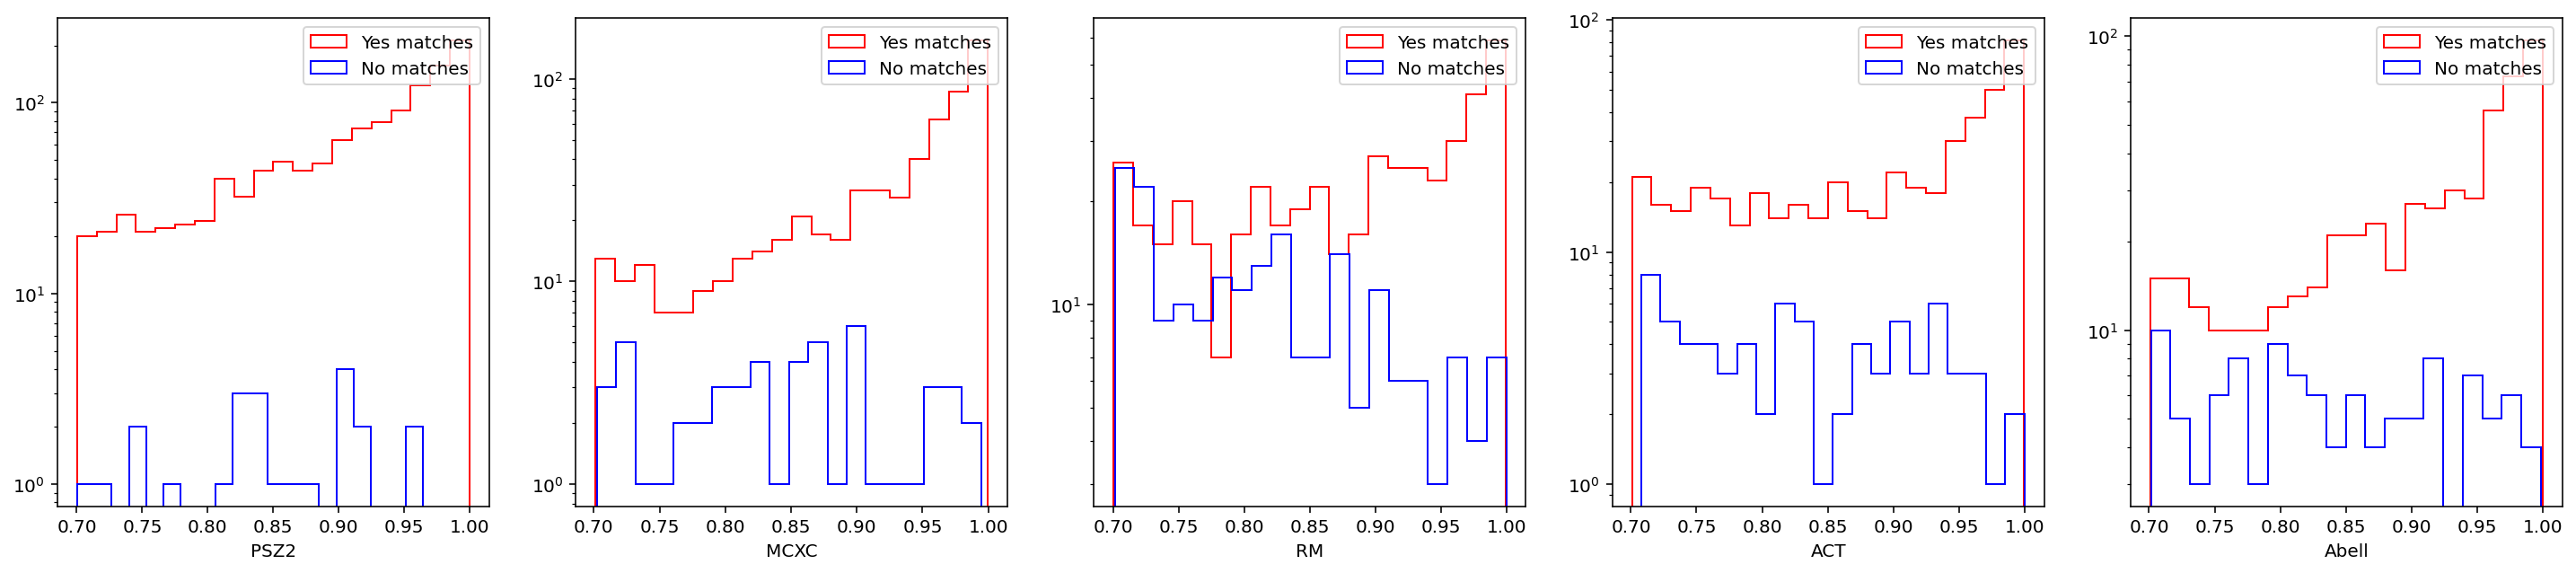

In [27]:
_, ax = plt.subplots(1, len(true_cats), figsize=(len(true_cats) * 5, 5))
for i, tr_cat in enumerate(true_cats):
    match_2circles(ax[i], pd.read_csv(det_cat), pd.read_csv(tr_cat), max_pred_lim=0.7)
    ax[i].set_xlabel(os.path.splitext(os.path.basename(tr_cat))[0])

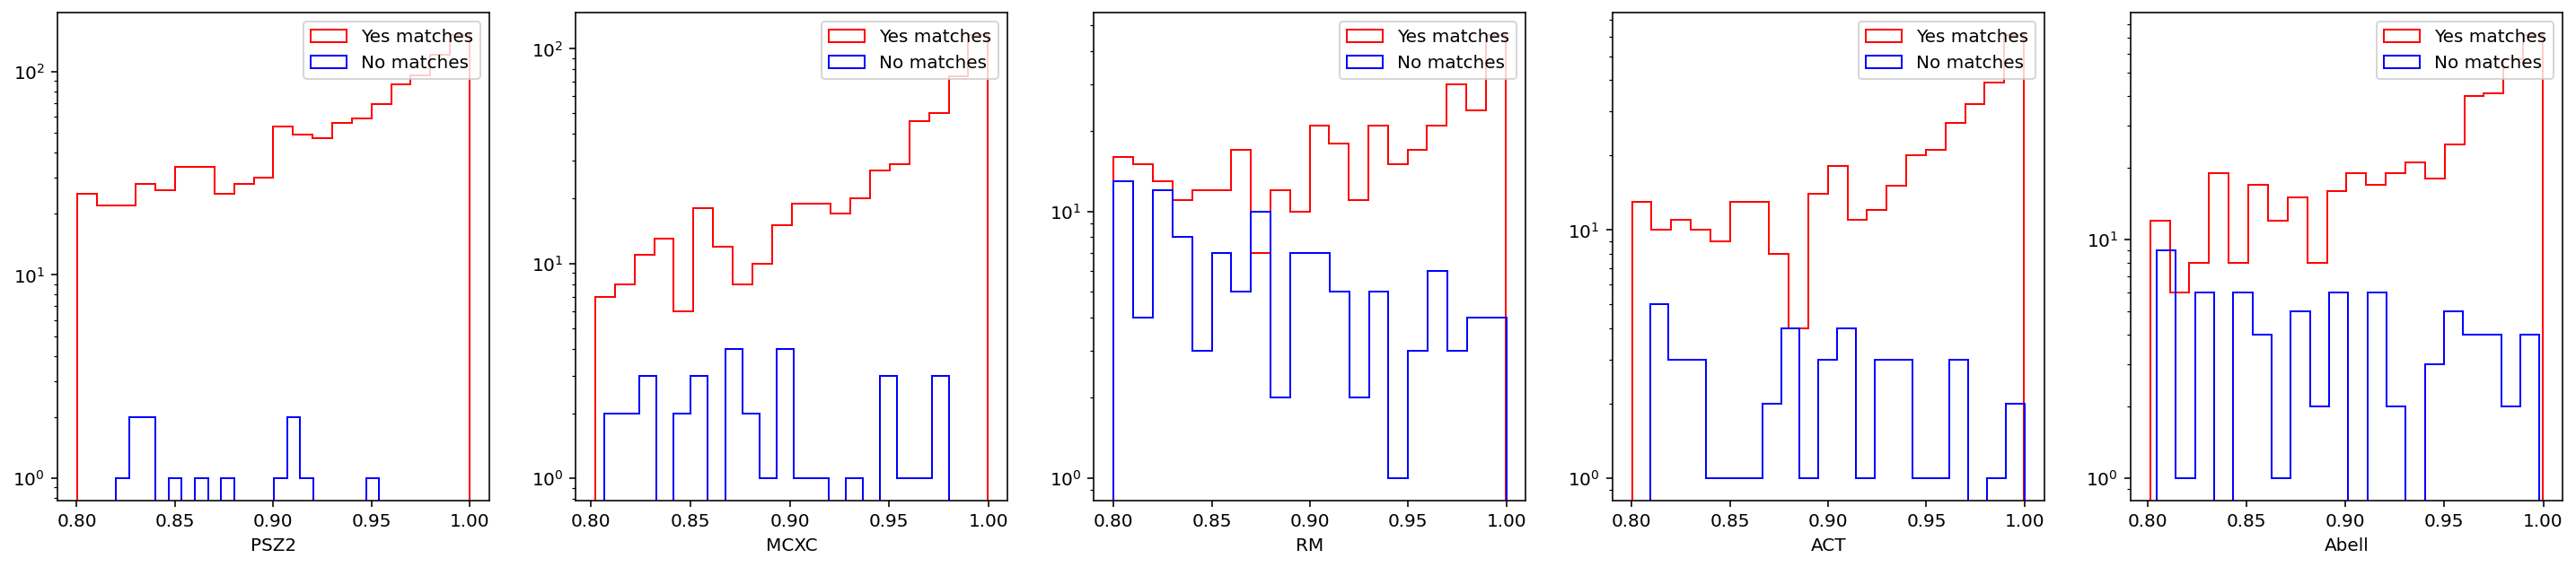

In [28]:
_, ax = plt.subplots(1, len(true_cats), figsize=(len(true_cats) * 5, 5))
for i, tr_cat in enumerate(true_cats):
    match_2circles(ax[i], pd.read_csv(det_cat), pd.read_csv(tr_cat), max_pred_lim=0.8)
    ax[i].set_xlabel(os.path.splitext(os.path.basename(tr_cat))[0])

In [111]:
def map_nside2(ax, big_pix, det_cat_file, true_cats_dir='/home/rt2122/Data/original_catalogs/csv/', s=50, special_cats=None, 
              add_legend=True):
    
    matr = one_pixel_fragmentation(2, big_pix, 10)
    mdict = matr2dict(matr)
    
    def cut_cat(cat):
        cat = cat[radec2pix(cat['RA'], cat['DEC'], 2) == big_pix]
        cat.index = np.arange(len(cat))
        cat['pix11'] = radec2pix(cat['RA'], cat['DEC'], 2**11)
        cat['x'] = -1
        cat['y'] = -1
        for i in cat.index:
            cat.loc[i, 'x'], cat.loc[i, 'y'] = mdict[cat.loc[i, 'pix11']]
        return cat
    
    det_cat = cut_cat(pd.read_csv(det_cat_file))
    
    true_cats_files = next(os.walk(true_cats_dir))[-1]
    true_cats_files = [os.path.join(true_cats_dir, file) for file in true_cats_files]
    true_cats = {os.path.splitext(os.path.basename(file))[0] : cut_cat(pd.read_csv(file)) for file in true_cats_files}
    if special_cats is None:
        special_cats = list(true_cats)
    
    pic = np.ones_like(matr)
    pic[0, 0] = 0
    #_, ax = plt.subplots(1, 1, figsize=(15, 15))
    ax.imshow(pic, cmap='gray')
    ss = ax.scatter(det_cat['x'], det_cat['y'], marker='x', c='r', s=s)
    ss.set_label(os.path.splitext(os.path.basename(det_cat_file))[0])
    
    for name in true_cats:
        if not (name in special_cats):
            continue
        ss = ax.scatter(true_cats[name]['x'], true_cats[name]['y'], marker='v', alpha=0.6, s=s)
        ss.set_label(name)
    
    ax.set_xlabel(big_pix)
    if add_legend:
        ax.legend()

<ipython-input-111-70d3d691d6d4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['pix11'] = radec2pix(cat['RA'], cat['DEC'], 2**11)
<ipython-input-111-70d3d691d6d4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['x'] = -1
<ipython-input-111-70d3d691d6d4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

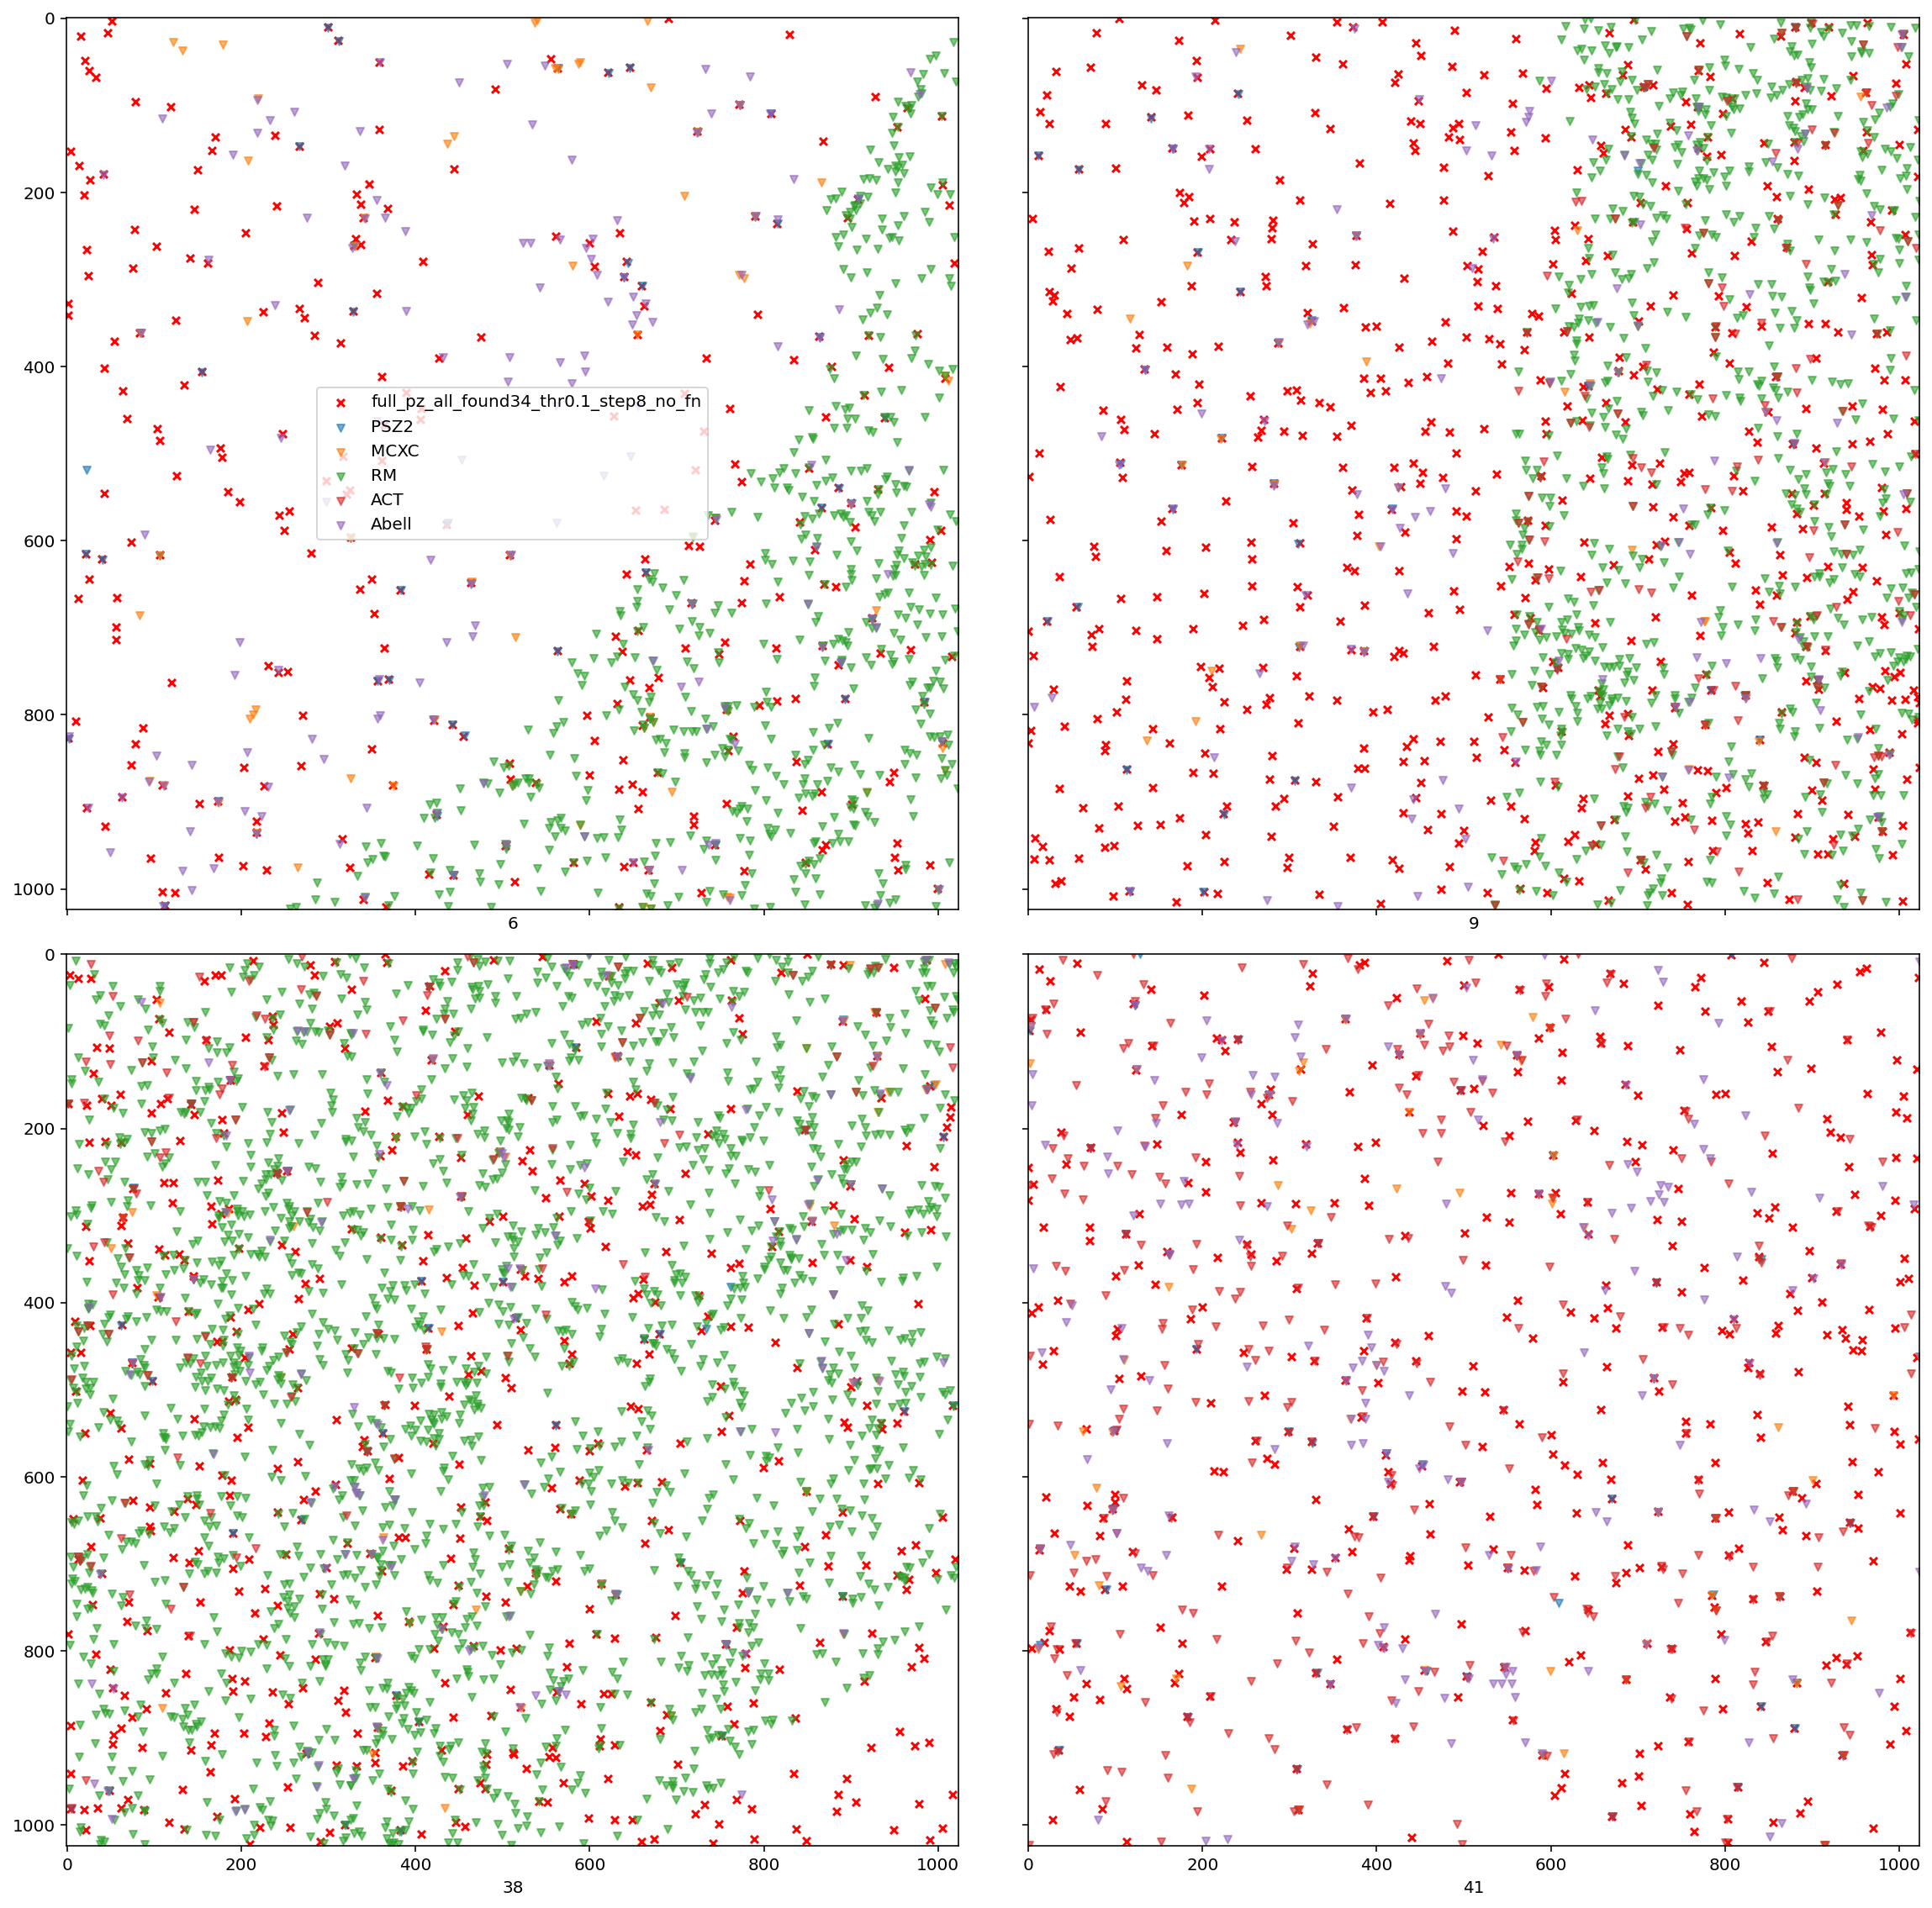

In [112]:
_, ax = plt.subplots(2, 2, figsize=(20, 20), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
det_cat = '/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv'
s=20
map_nside2(ax[0][0], 6, det_cat, s=s)
map_nside2(ax[0][1], 9, det_cat, add_legend=False, s=s)
map_nside2(ax[1][0], 38, det_cat, add_legend=False, s=s)
map_nside2(ax[1][1], 41, det_cat, add_legend=False, s=s)

<ipython-input-111-70d3d691d6d4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['pix11'] = radec2pix(cat['RA'], cat['DEC'], 2**11)
<ipython-input-111-70d3d691d6d4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['x'] = -1
<ipython-input-111-70d3d691d6d4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

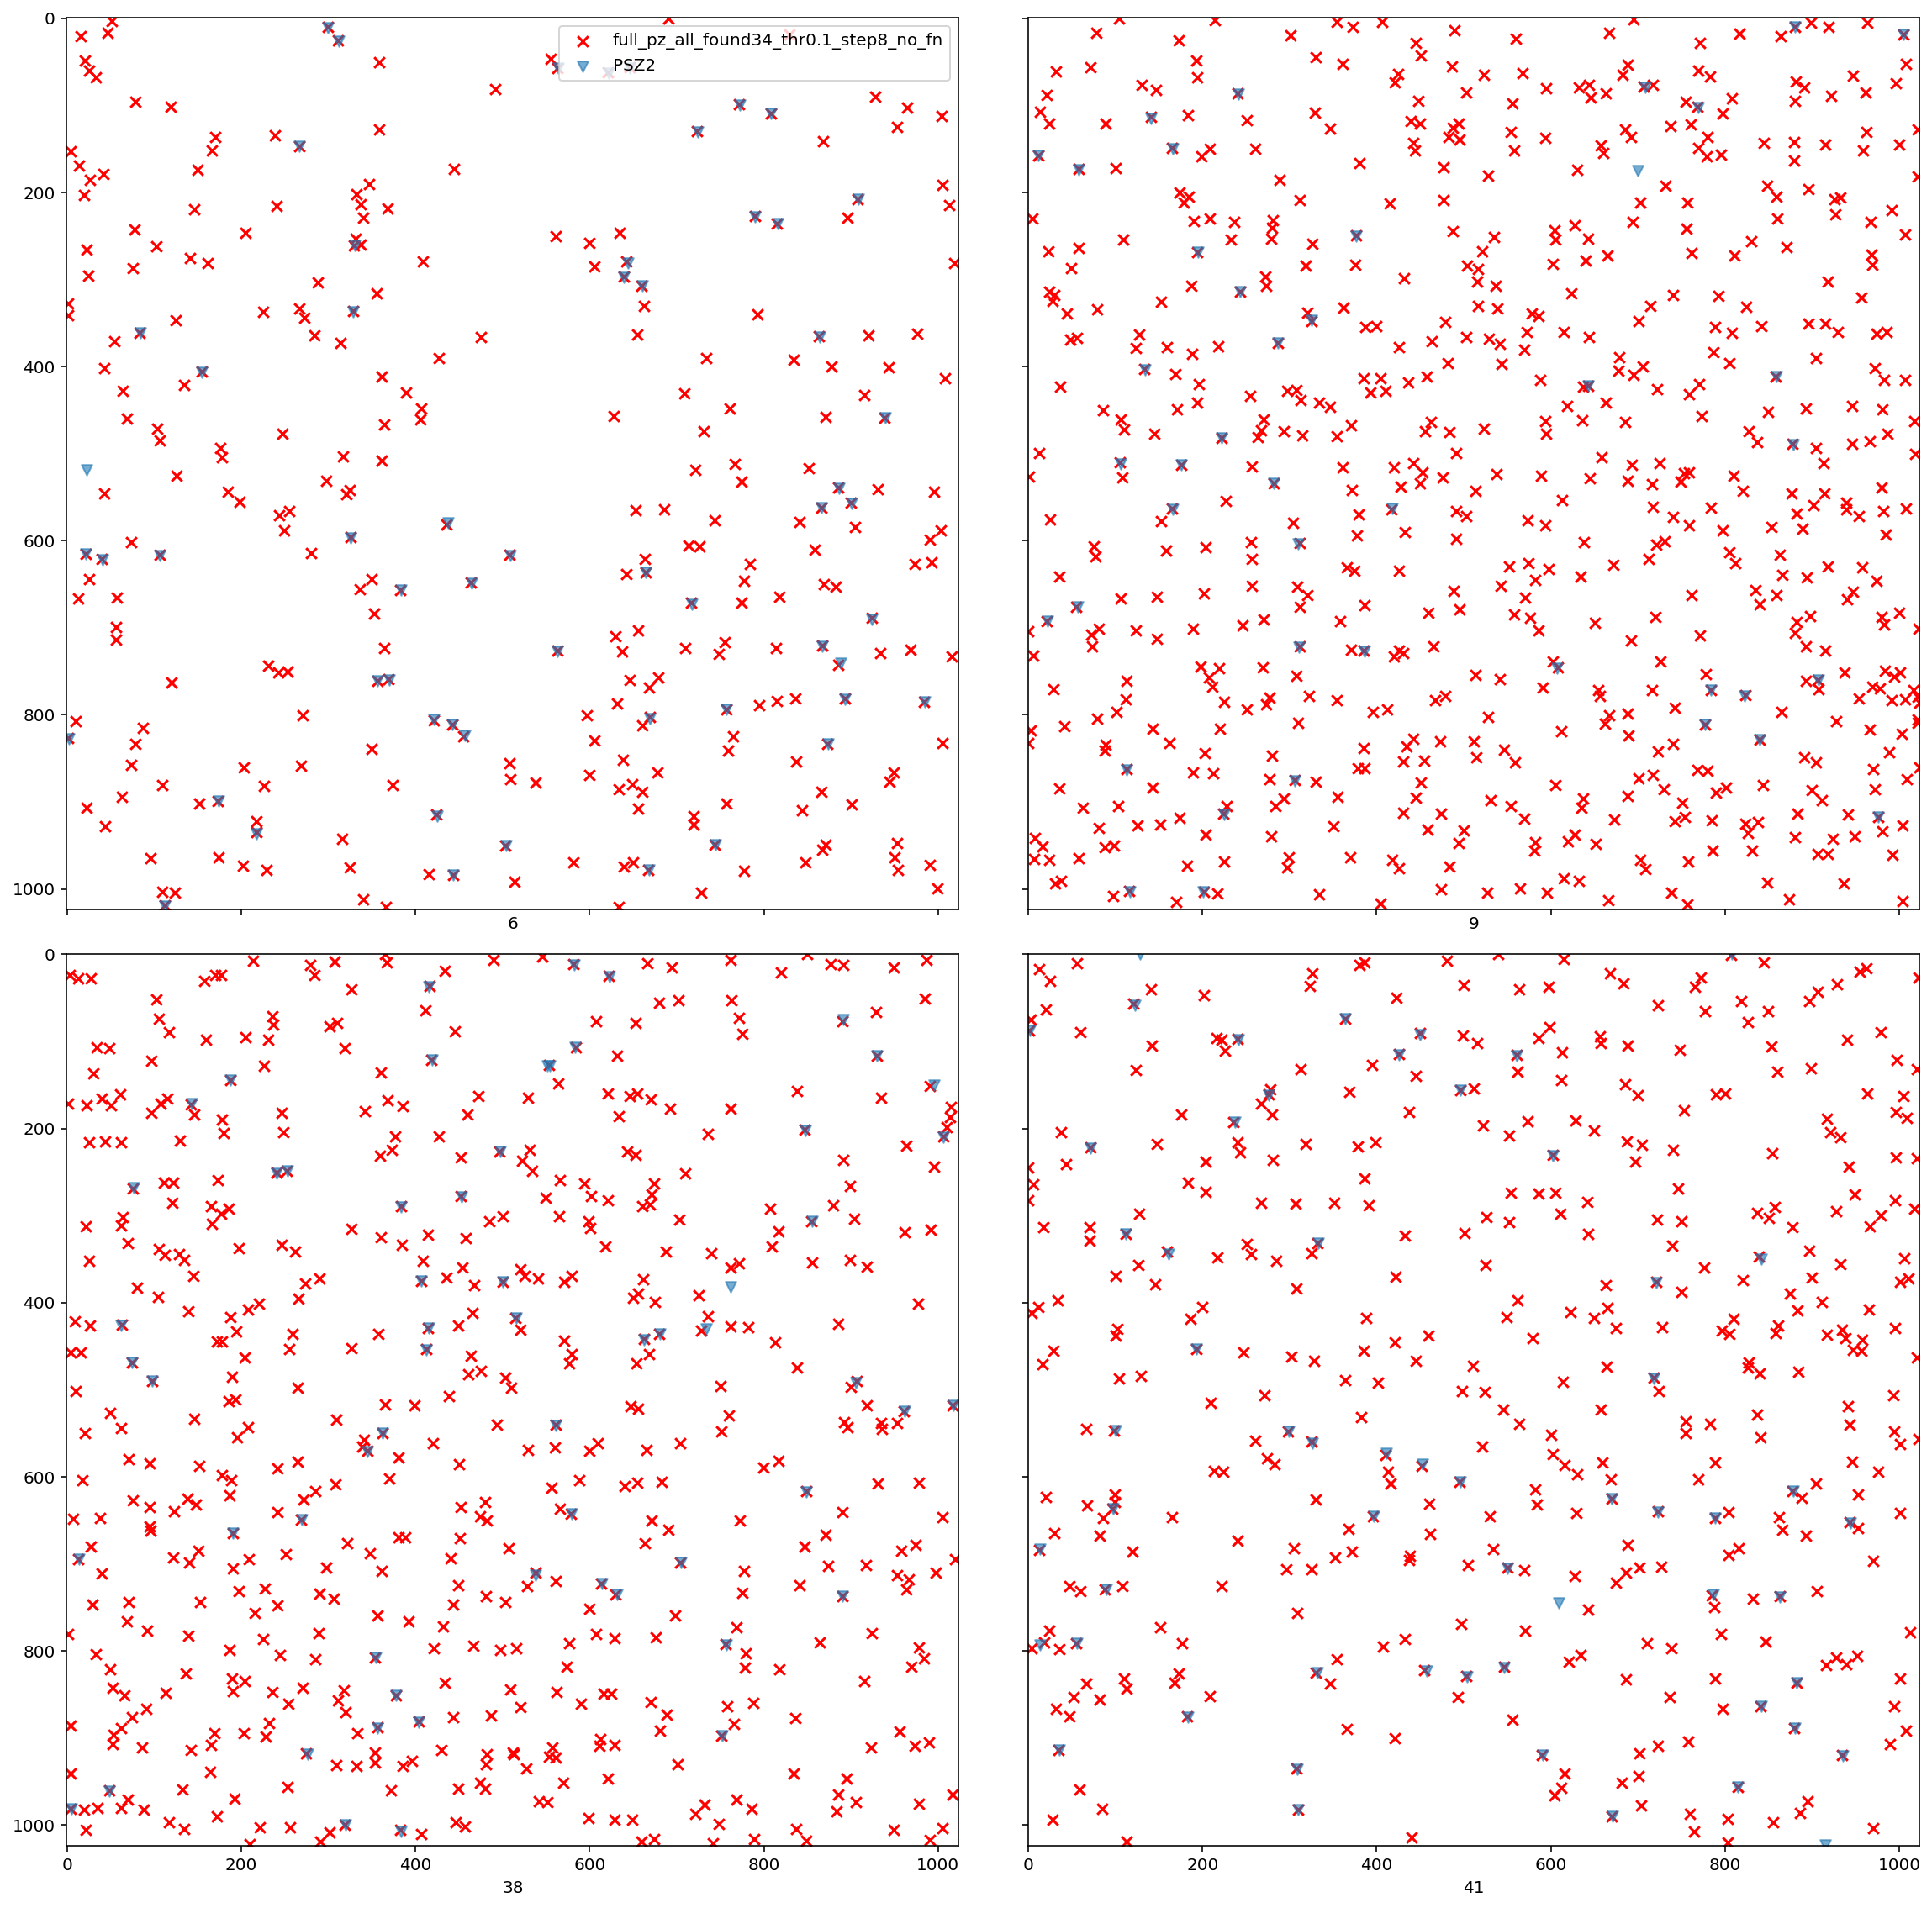

In [116]:
_, ax = plt.subplots(2, 2, figsize=(20, 20), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
det_cat = '/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv'
s=40
spec = ['PSZ2']
map_nside2(ax[0][0], 6, det_cat, s=s, special_cats=spec)
map_nside2(ax[0][1], 9, det_cat, add_legend=False, s=s, special_cats=spec)
map_nside2(ax[1][0], 38, det_cat, add_legend=False, s=s, special_cats=spec)
map_nside2(ax[1][1], 41, det_cat, add_legend=False, s=s, special_cats=spec)

<ipython-input-111-70d3d691d6d4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['pix11'] = radec2pix(cat['RA'], cat['DEC'], 2**11)
<ipython-input-111-70d3d691d6d4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['x'] = -1
<ipython-input-111-70d3d691d6d4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

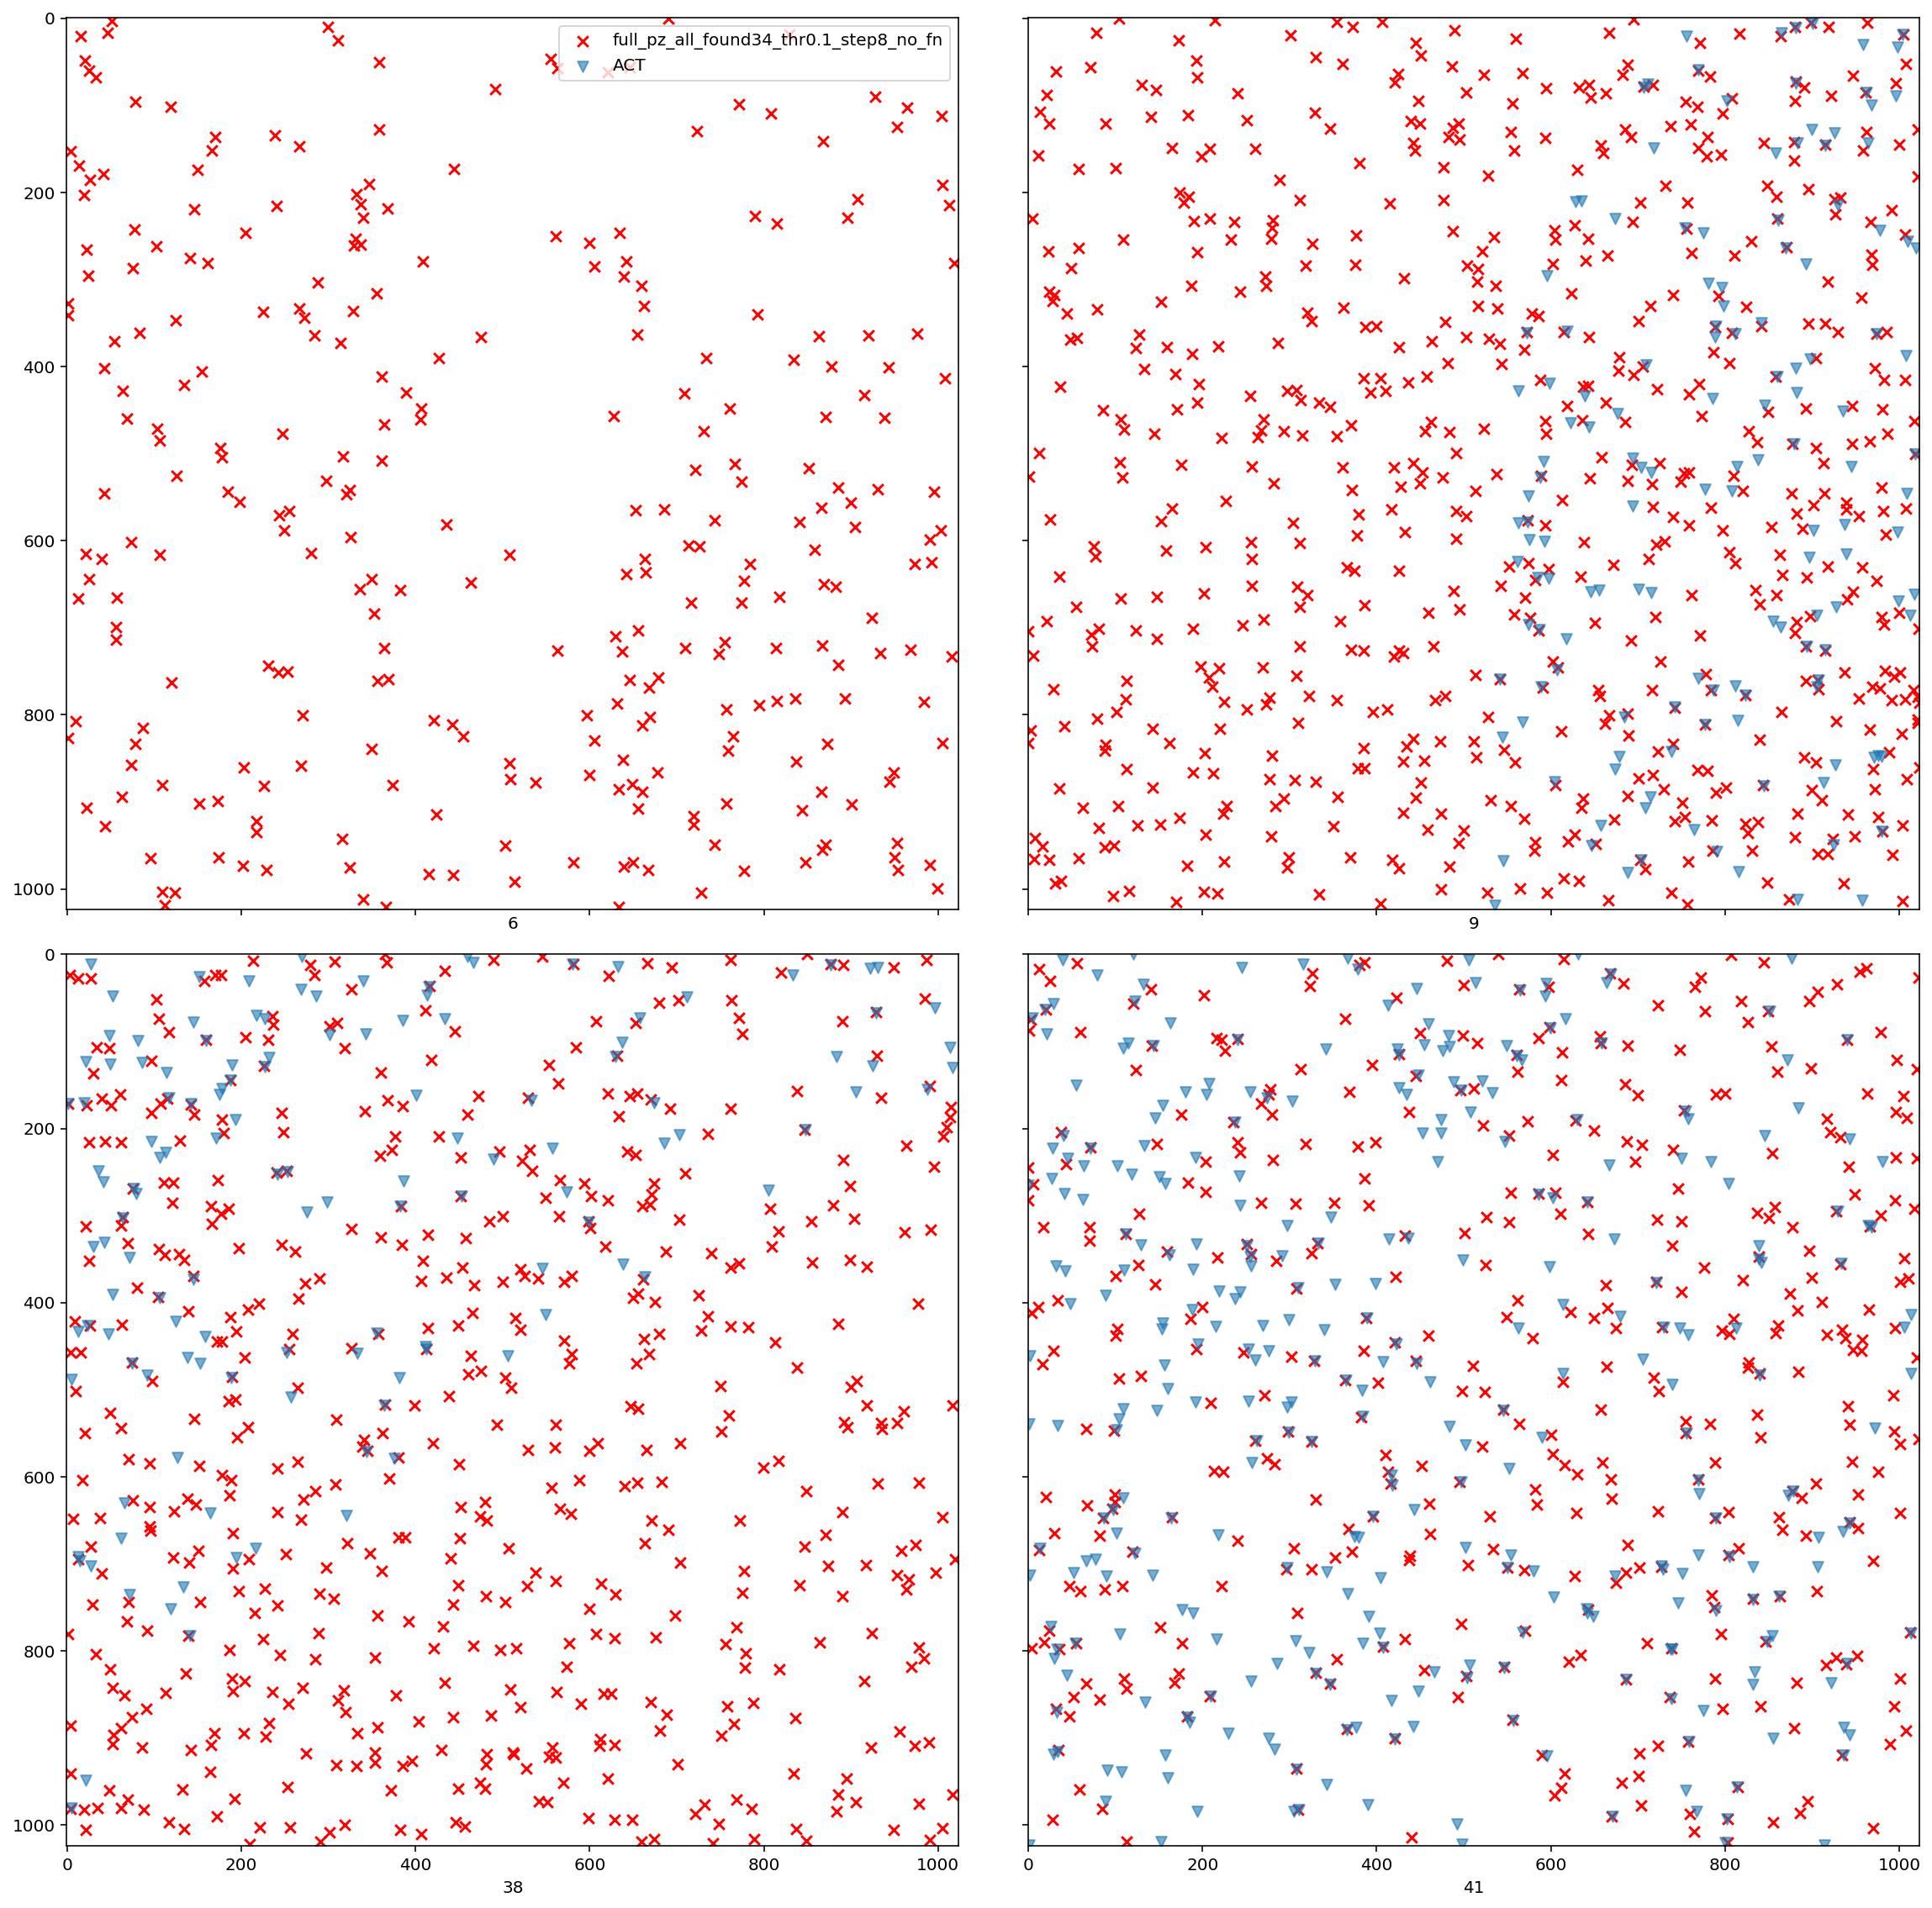

In [115]:
_, ax = plt.subplots(2, 2, figsize=(20, 20), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
det_cat = '/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv'
s=40
spec = ['ACT']
map_nside2(ax[0][0], 6, det_cat, s=s, special_cats=spec)
map_nside2(ax[0][1], 9, det_cat, add_legend=False, s=s, special_cats=spec)
map_nside2(ax[1][0], 38, det_cat, add_legend=False, s=s, special_cats=spec)
map_nside2(ax[1][1], 41, det_cat, add_legend=False, s=s, special_cats=spec)